# Google Play Store Apps Data Analysis and Sentimet Analysis

In [ ]:
!pip install pyspark==3.2.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyspark
from pyspark.sql import SparkSession

In [ ]:
spark= SparkSession.builder.appName("Googleplaystoreapps").getOrCreate()

In [ ]:
hdfs_path_googleplaystore= "hdfs://localhost:3229/hdoop/googleplaystore.csv"
hdfs_path_googleplaystore_user_reviews= "hdfs://localhost:3229/hdoop/googleplaystore_user_reviews.csv"

app_df= spark.read.csv(hdfs_path_googleplaystore, header=True, inferSchema=True)
sentiment_df= spark.read.csv(hdfs_path_googleplaystore_user_reviews, header=True, inferSchema=True)

In [ ]:
app_df.count()

10841

In [ ]:
app_df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [ ]:
sentiment_df.show()

+--------------------+--------------------+--------------------+------------------+----------------------+
|                 App|   Translated_Review|           Sentiment|Sentiment_Polarity|Sentiment_Subjectivity|
+--------------------+--------------------+--------------------+------------------+----------------------+
|10 Best Foods for...|"I like eat delic...| also ""Best Befo...|          Positive|                     1|
|10 Best Foods for...|This help eating ...|            Positive|              0.25|           0.288461538|
|10 Best Foods for...|                 nan|                 nan|               nan|                   nan|
|10 Best Foods for...|Works great espec...|            Positive|               0.4|                 0.875|
|10 Best Foods for...|        Best idea us|            Positive|                 1|                   0.3|
|10 Best Foods for...|            Best way|            Positive|                 1|                   0.3|
|10 Best Foods for...|             Am

In [ ]:
sentiment_df.count()

64295

In [ ]:
sentiment_df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Translated_Review: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- Sentiment_Polarity: string (nullable = true)
 |-- Sentiment_Subjectivity: string (nullable = true)



## Data Preprocessing

### Data Cleaning

#### Cleaning the app_df dataframe first.

In [ ]:
import numpy as np
from pyspark.sql.functions import isnan, when, count, col, sum, randn, mean,trim,lower, stddev, collect_list, regexp_replace

In [ ]:
#Dropping the column with we are not going to use
app_df = app_df.drop('Content Rating', 'Current Ver','Android Ver', 'Last Updated', 'Genres')

In [ ]:
app_df.show(5)

+--------------------+--------------+------+-------+----+-----------+----+-----+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|
+--------------------+--------------+------+-------+----+-----------+----+-----+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|    10,000+|Free|    0|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|   500,000+|Free|    0|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5,000,000+|Free|    0|
|Sketch - Draw & P...|ART_AND_DESIGN|   4.5| 215644| 25M|50,000,000+|Free|    0|
|Pixel Draw - Numb...|ART_AND_DESIGN|   4.3|    967|2.8M|   100,000+|Free|    0|
+--------------------+--------------+------+-------+----+-----------+----+-----+
only showing top 5 rows



In [ ]:
app_df.agg(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in app_df.columns]).show()

+---+--------+------+-------+----+--------+----+-----+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|
+---+--------+------+-------+----+--------+----+-----+
|  0|       0|  1474|      0|   0|       0|   1|    0|
+---+--------+------+-------+----+--------+----+-----+



In [ ]:
#Cleaning "Type" column
counts_df = app_df.groupBy("Type").agg(count("*").alias("count"))
counts_df.show()

+------+-----+
|  Type|count|
+------+-----+
|     0|    1|
|102248|    1|
|   NaN|    1|
|  Free|10037|
|  Paid|  800|
|  2509|    1|
+------+-----+



In [ ]:
# replace null and NaN values in the "Type" column with "Free"
app_df = app_df.withColumn("Type", when(col("Type").isNull() | isnan(col("Type")), "Free").otherwise(col("Type")))

# count the number of null and NaN values in the "Type" column
null_count = app_df.filter(col("Type").isNull() | isnan(col("Type"))).count()

# display the number of null and NaN values
print(null_count)

0


In [ ]:
# # #cleaning "Rating" column
# # replace null values in "Rating" column with mean value
# mean_rating = app_df.select(mean("Rating")).first()[0]
# app_df = app_df.withColumn("Rating", when(col("Rating").isNull(), mean_rating).otherwise(col("Rating")))

# # drop any remaining rows with null values in the dataframe
# app_df = app_df.dropna()

Dropping the row containing nan didnt work so i m going to do this code after converting spark df to pandas df

In [ ]:
app_df.agg(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in app_df.columns]).show()


+---+--------+------+-------+----+--------+----+-----+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|
+---+--------+------+-------+----+--------+----+-----+
|  0|       0|  1474|      0|   0|       0|   0|    0|
+---+--------+------+-------+----+--------+----+-----+



#### Cleaning the sentiment_df dataframe.

In [ ]:
#Dropping the column with we are not going to use
sentiment_df = sentiment_df.drop('Sentiment_Polarity', 'Sentiment_Subjectivity')

In [ ]:
sentiment_df.agg(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sentiment_df.columns]).show()

+---+-----------------+---------+
|App|Translated_Review|Sentiment|
+---+-----------------+---------+
|  0|            26868|    26863|
+---+-----------------+---------+



In [ ]:
#Now for the "Sentiment" column

# convert 'Positive' to 2, 'Negative' to 1, 'Neutral' to 0
sentiment_df = sentiment_df.withColumn('Sentiment', when(col('Sentiment') == 'Positive', 2)
                                    .when(col('Sentiment') == 'Negative', 1)
                                    .when(col('Sentiment') == 'Neutral', 0))

Converting the unquie values of the coulmn into numeric form such as Positive to 2 , Negative to 1 and Neutral to 0.

In [ ]:
sentiment_df.show(10)

+--------------------+--------------------+---------+
|                 App|   Translated_Review|Sentiment|
+--------------------+--------------------+---------+
|10 Best Foods for...|"I like eat delic...|     null|
|10 Best Foods for...|This help eating ...|        2|
|10 Best Foods for...|                 nan|     null|
|10 Best Foods for...|Works great espec...|        2|
|10 Best Foods for...|        Best idea us|        2|
|10 Best Foods for...|            Best way|        2|
|10 Best Foods for...|             Amazing|        2|
|10 Best Foods for...|                 nan|     null|
|10 Best Foods for...|Looking forward app,|        0|
|10 Best Foods for...|It helpful site !...|        0|
+--------------------+--------------------+---------+
only showing top 10 rows



In [ ]:
# remove rows with null values
sentiment_df = sentiment_df.dropna()

In [ ]:
sentiment_df.show(10)

+--------------------+--------------------+---------+
|                 App|   Translated_Review|Sentiment|
+--------------------+--------------------+---------+
|10 Best Foods for...|This help eating ...|        2|
|10 Best Foods for...|Works great espec...|        2|
|10 Best Foods for...|        Best idea us|        2|
|10 Best Foods for...|            Best way|        2|
|10 Best Foods for...|             Amazing|        2|
|10 Best Foods for...|Looking forward app,|        0|
|10 Best Foods for...|It helpful site !...|        0|
|10 Best Foods for...|           good you.|        2|
|10 Best Foods for...|Useful informatio...|        2|
|10 Best Foods for...|Thank you! Great ...|        2|
+--------------------+--------------------+---------+
only showing top 10 rows



Now, the both the data frame app_df and sentiment_df are cleaned. we can merge them into one dataframe.

In [ ]:
merged_df = app_df.join(sentiment_df, on='App')

Merging the two dataframe "app_df" and "sentiment_df" in one dataframe on column "App".

In [ ]:
merged_df.show(5)

+--------------------+------------------+------+-------+----+--------+----+-----+--------------------+---------+
|                 App|          Category|Rating|Reviews|Size|Installs|Type|Price|   Translated_Review|Sentiment|
+--------------------+------------------+------+-------+----+--------+----+-----+--------------------+---------+
|10 Best Foods for...|HEALTH_AND_FITNESS|     4|   2490|3.8M|500,000+|Free|    0|This help eating ...|        2|
|10 Best Foods for...|HEALTH_AND_FITNESS|     4|   2490|3.8M|500,000+|Free|    0|This help eating ...|        2|
|10 Best Foods for...|HEALTH_AND_FITNESS|     4|   2490|3.8M|500,000+|Free|    0|Works great espec...|        2|
|10 Best Foods for...|HEALTH_AND_FITNESS|     4|   2490|3.8M|500,000+|Free|    0|Works great espec...|        2|
|10 Best Foods for...|HEALTH_AND_FITNESS|     4|   2490|3.8M|500,000+|Free|    0|        Best idea us|        2|
+--------------------+------------------+------+-------+----+--------+----+-----+---------------

### Converting Spark dataframe to Pandas Dataframe

In [ ]:
final_df= merged_df.toPandas()

In [ ]:
final_df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Translated_Review,Sentiment
0,10 Best Foods for You,HEALTH_AND_FITNESS,4,2490,3.8M,"500,000+",Free,0,This help eating healthy exercise regular basis,2
1,10 Best Foods for You,HEALTH_AND_FITNESS,4,2490,3.8M,"500,000+",Free,0,This help eating healthy exercise regular basis,2
2,10 Best Foods for You,HEALTH_AND_FITNESS,4,2490,3.8M,"500,000+",Free,0,Works great especially going grocery store,2
3,10 Best Foods for You,HEALTH_AND_FITNESS,4,2490,3.8M,"500,000+",Free,0,Works great especially going grocery store,2
4,10 Best Foods for You,HEALTH_AND_FITNESS,4,2490,3.8M,"500,000+",Free,0,Best idea us,2


In [ ]:
final_df.isnull().sum()

App                  0
Category             0
Rating               0
Reviews              0
Size                 0
Installs             0
Type                 0
Price                0
Translated_Review    0
Sentiment            0
dtype: int64

## Feature Selection

In [ ]:
import pandas as pd

#### For "Install" column

In [ ]:
#Removing the "+" and "," from the column
final_df['Installs'] = final_df['Installs'].astype(str) #converting the column to string
final_df['Installs'] = final_df['Installs'].str.replace('+', '').str.replace(',', '')
final_df['Installs'] = pd.to_numeric(final_df['Installs'])

<ipython-input-624-395406273217>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_df['Installs'] = final_df['Installs'].str.replace('+', '').str.replace(',', '')


In [ ]:
final_df.Installs.value_counts()

100000000     15843
10000000      14039
1000000       10804
5000000        8734
50000000       6207
100000         4968
500000         4132
500000000      2207
1000000000     2126
50000           932
10000           770
1000            187
Name: Installs, dtype: int64

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70949 entries, 0 to 70948
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   App                70949 non-null  object
 1   Category           70949 non-null  object
 2   Rating             70949 non-null  object
 3   Reviews            70949 non-null  object
 4   Size               70949 non-null  object
 5   Installs           70949 non-null  int64 
 6   Type               70949 non-null  object
 7   Price              70949 non-null  object
 8   Translated_Review  70949 non-null  object
 9   Sentiment          70949 non-null  int32 
dtypes: int32(1), int64(1), object(8)
memory usage: 5.1+ MB


Now, converting the other column into numeric value too.

In [ ]:
final_df['Rating'] = pd.to_numeric(final_df['Rating'], errors='coerce')   #Converting its values into numeric format

In [ ]:
final_df.Rating.dtype

dtype('float64')

#### For "Size" column

In [ ]:
#Since the size column is object datatype. converting it into numeric form
final_df.Size.dtype

dtype('O')

In [ ]:
final_df.Size.value_counts()

Varies with device    26883
97M                    1923
74M                    1736
14M                    1730
33M                    1600
                      ...  
3.2M                      3
8.7M                      1
118k                      1
68M                       1
73M                       1
Name: Size, Length: 168, dtype: int64

As we know, the size of an app is always given in form of MB or GB. In this column we can see that M is denoted as MB and K is denoted as KB. For data anyalsis we have to bring the data in simple form. firstly, we have to remove the "M" and "k" from the column and diving the Kb value with 1024, which basically convertes Kb into Mb.

In [ ]:
# Removing M from values in Size column, if present
final_df['Size'] = final_df['Size'].astype(str)  #converting the column to string
final_df['Size'] = final_df['Size'].str.replace('M', '')

In [ ]:
# Removing 'varies with device' and replacing with 'NaN'
final_df.Size = final_df['Size'].str.replace('Varies with device','NaN') 

In [ ]:
# converting 'KB' into by and dividing kb values by 1024
final_df.Size = final_df.Size.map(lambda x : float(str(x).replace('k',''))/1024 if 'k' in str(x) else x)

# converting all values into float
final_df.Size = final_df.Size.apply(lambda x : float(x))

In [ ]:
final_df.Size = final_df.Size.apply(lambda x : round(x,2))

In [ ]:
final_df.Size.dtype

dtype('float64')

### For Reviews column

In [ ]:
final_df.Reviews.dtype

dtype('O')

In [ ]:
final_df.Reviews.value_counts()

91031      744
6290507    654
1535973    614
91033      558
1873523    496
          ... 
483565       1
9498         1
2251012      1
566          1
29265        1
Name: Reviews, Length: 1068, dtype: int64

In [ ]:
final_df['Reviews'] = pd.to_numeric(final_df['Reviews'])

### For Price column

In [ ]:
final_df.Price.value_counts()

0          70196
$3.99        210
$9.99        187
$11.99       148
$2.49         70
$0.99         56
$29.99        40
$4.99         39
$6.99          3
Name: Price, dtype: int64

As we can see, there is a dollar sign before the price figure. Additionally, the values in this column have an object data type. 
Therefore, let's eliminate the dollor sign and convert this column to a numeric value.

In [ ]:
#Removing '$' and converting to numeric column
if final_df['Price'].dtype != 'object':
    final_df['Price'] = final_df['Price'].astype(str) 
    
final_df.Price = final_df.Price.str.replace('$','')
final_df.Price = pd.to_numeric(final_df.Price)

<ipython-input-644-50fcd3643cc1>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_df.Price = final_df.Price.str.replace('$','')


In [ ]:
final_df.Price.dtype

dtype('float64')

In [ ]:
# checking if any duplicates are left or not
final_df.duplicated().sum().any()   # .any() returns False for 0 and True if not 0 (if duplicates are available)

False

In [ ]:
# dropping duplicate rows
final_df.drop_duplicates(inplace=True)

# Again checking if any duplicates are left or not
print(final_df.duplicated().sum().any()) 

False


In [ ]:
final_df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Translated_Review,Sentiment
0,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,This help eating healthy exercise regular basis,2
2,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Works great especially going grocery store,2
4,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Best idea us,2
6,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Best way,2
8,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Amazing,2
...,...,...,...,...,...,...,...,...,...,...
70944,Housing-Real Estate & Property,LIFESTYLE,4.1,28301,NaN,1000000,Free,0.0,Most ads older many agents ..not much owner po...,2
70945,Housing-Real Estate & Property,LIFESTYLE,4.1,28301,NaN,1000000,Free,0.0,"If photos posted portal load, fit purpose. I'm...",2
70946,Housing-Real Estate & Property,LIFESTYLE,4.1,28301,NaN,1000000,Free,0.0,"Dumb app, I wanted post property rent give opt...",1
70947,Housing-Real Estate & Property,LIFESTYLE,4.1,28301,NaN,1000000,Free,0.0,I property business got link SMS happy perform...,2


We can see that there has been changes in rows numbers because we have removed duplicates data.

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39683 entries, 0 to 70948
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   App                39683 non-null  object 
 1   Category           39683 non-null  object 
 2   Rating             39645 non-null  float64
 3   Reviews            39683 non-null  int64  
 4   Size               26071 non-null  float64
 5   Installs           39683 non-null  int64  
 6   Type               39683 non-null  object 
 7   Price              39683 non-null  float64
 8   Translated_Review  39683 non-null  object 
 9   Sentiment          39683 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(4)
memory usage: 3.2+ MB


In [ ]:
final_df.App.value_counts()

8 Ball Pool                                           672
Angry Birds Classic                                   520
Helix Jump                                            516
Bowmasters                                            480
Bubble Shooter                                        444
                                                     ... 
All-in-One Mahjong 3 FREE                               1
Calculator - unit converter                             1
CBS News                                                1
Best Ovulation Tracker Fertility Calendar App Glow      1
DashClock Widget                                        1
Name: App, Length: 816, dtype: int64

We can conclude that there might be applications for which there are multiple rows. Therefore, since all columns other than reviews are for the same value, they will all have the same values in that scenario. Similarly, it is recommended to select the row for which there are the most reviews because this indicates that the particular row contains the most recent data. Let's implement this concept and choose only those distinct apps that have the highest values in the reviews number column.This demonstrates that distinct apps exist with identical values in all columns but varying values in the reviews column. Therefore, it is best to change our dataframe so that it contains the information required for each individual app.

# Data Visualization

In [ ]:
#importing the necessary libraries for visualization.
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

#setting styles and size for the plot
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['figure.facecolor'] = '#00000000'

### What are the top 10 most downloaded apps from the Google Play store?

In [ ]:
# the code below helps to count the apps repeated or apps's total number in the apps_df dataframe
apps= dict(final_df.App.value_counts())

# using the above dictionary to create new dictionary to create a new dataframe
apps_dataframe = {
    'App':list(apps.keys()),
    'Count':list(apps.values())
}

# Creating the DataFrame from the dictionary above
top_apps = pd.DataFrame(apps_dataframe)
top_apps

,App,Count
0,8 Ball Pool,672
1,Angry Birds Classic,520
2,Helix Jump,516
3,Bowmasters,480
4,Bubble Shooter,444
...,...,...
811,All-in-One Mahjong 3 FREE,1
812,Calculator - unit converter,1
813,CBS News,1
814,Best Ovulation Tracker Fertility Calendar App ...,1


In [ ]:
# This returns a dataframe that contains apps with their maximum installs
total_installed_apps = final_df.groupby('App')[['Installs']].max()
total_installed_apps

,Installs
App,
10 Best Foods for You,500000
11st,10000000
1800 Contacts - Lens Store,1000000
1LINE – One Line with One Touch,10000000
2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif,10000000
...,...
Hotels.com: Book Hotel Rooms & Find Vacation Deals,10000000
Hotspot Shield Free VPN Proxy & Wi-Fi Security,50000000
Hotstar,100000000


In [ ]:
# Merging the two previous dataframes into a one dataframe ,and sorting it with accordance to top 15 highest Install values from it.
highest_15_apps_accordingto_installs = top_apps.merge(total_installed_apps, on = 'App', how = 'left').sort_values('Installs',ascending = False).head(15)

In [ ]:
highest_15_apps_accordingto_installs

,App,Count,Installs
31,Hangouts,160,1000000000
92,Gmail,80,1000000000
741,Google Street View,8,1000000000
5,Google Photos,380,1000000000
134,Google,72,1000000000
44,Google News,114,1000000000
761,Google+,4,1000000000
16,Facebook,242,1000000000
686,Google Duo - High Quality Video Calls,18,500000000
634,Flipboard: News For Our Time,26,500000000


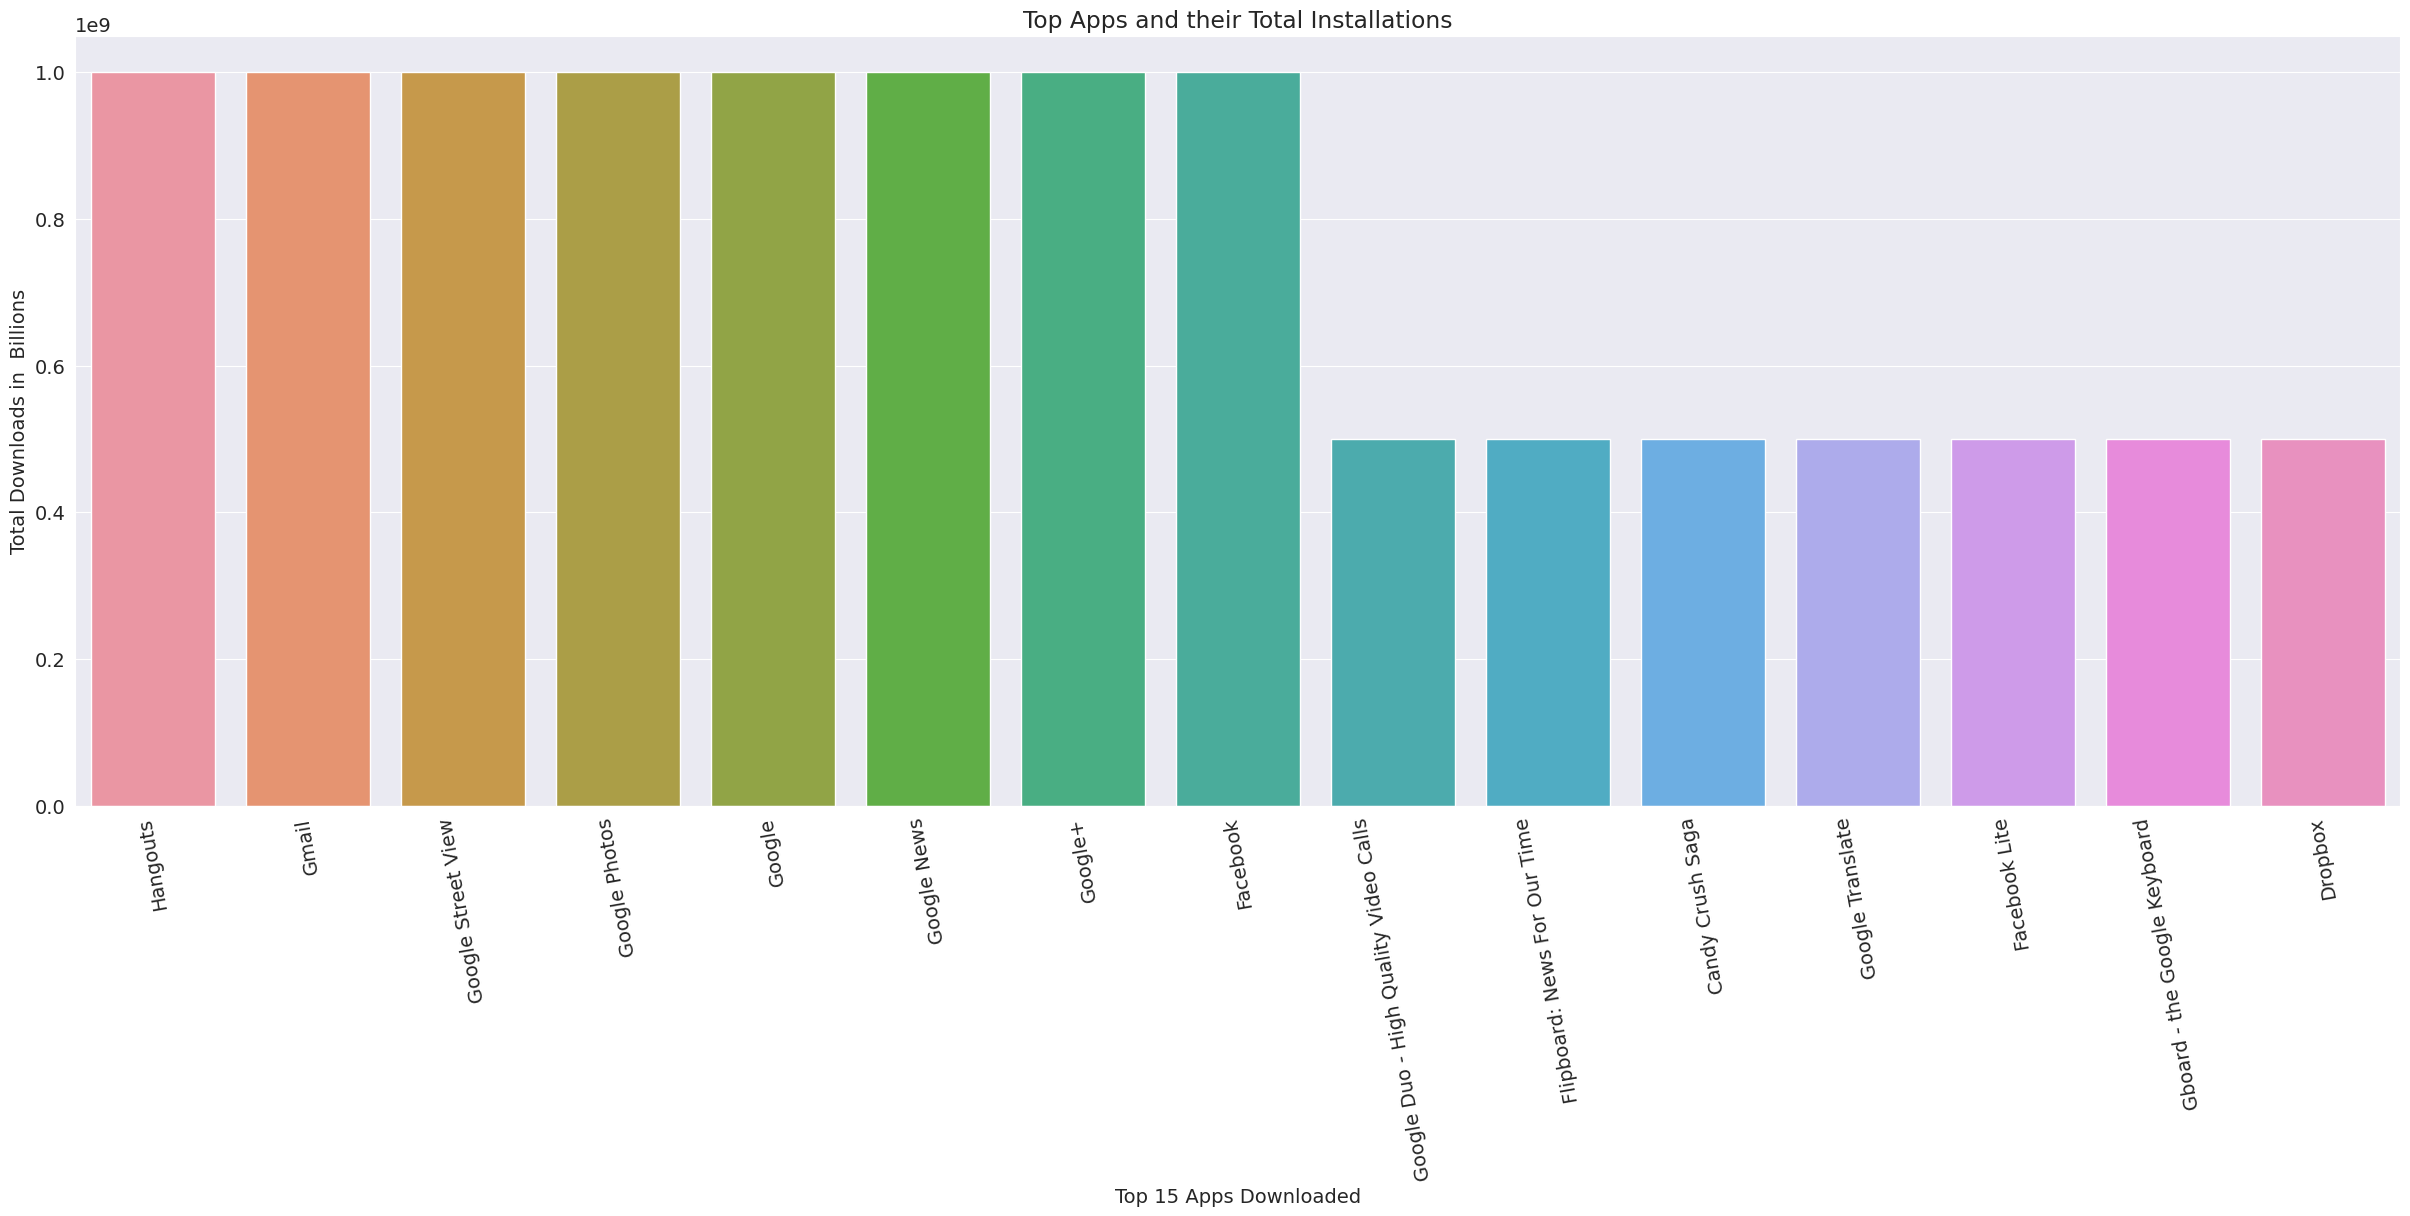

In [ ]:
# Plotting our bar graph: Top Apps and their Installations
plt.figure(figsize=(30,10))
plt.xticks(rotation=100)
sns.barplot(x = highest_15_apps_accordingto_installs.App, y = highest_15_apps_accordingto_installs.Installs)
plt.title("Top Apps and their Total Installations")
plt.xlabel("Top 15 Apps Downloaded")
plt.ylabel("Total Downloads in  Billions")
plt.show();

From the above bar diagram, we can say the top 15 app and it has been downloaded for like more than billons times. Most of the app is related to social media and google related apps such as gmail, facebook, google, google play games and so on.

### According to the count, which category has most Apps?

In [ ]:
# using value_counts() to count the occurrence of individual Category in the Category column ,and storing a resultant as a dictionary
dict1 = dict(final_df.Category.value_counts())

# Using the dictionary above to create a new dictionary
dataframe = {'Category':list(dict1.keys()),
             'Count':list(dict1.values())}

# Converting the dictionary above into a dataframe
top_Category = pd.DataFrame(dataframe)
top_Category

,Category,Count
0,GAME,9083
1,FAMILY,3487
2,HEALTH_AND_FITNESS,1861
3,TRAVEL_AND_LOCAL,1748
4,TOOLS,1633
5,PRODUCTIVITY,1619
6,SPORTS,1590
7,FINANCE,1547
8,PHOTOGRAPHY,1494
9,DATING,1469


In [ ]:
# a new dataframe that consists of Category and their total installs
total_installed_category = final_df.groupby('Category')[['Installs']].sum()
total_installed_category

,Installs
Category,
ART_AND_DESIGN,706700000
AUTO_AND_VEHICLES,413100000
BEAUTY,489200000
BOOKS_AND_REFERENCE,28348100000
BUSINESS,7529900000
COMICS,70100000
COMMUNICATION,282724000000
DATING,2052480000
EDUCATION,11483190000


In [ ]:
# lets join the previous two dataframes
highest_15_Category_accordingto_installs = top_Category.merge(total_installed_category, on = 'Category',how = 'left').sort_values('Count',ascending = False).head(15)
highest_15_Category_accordingto_installs

,Category,Count,Installs
0,GAME,9083,568577400000
1,FAMILY,3487,102317790000
2,HEALTH_AND_FITNESS,1861,19169900000
3,TRAVEL_AND_LOCAL,1748,33712300000
4,TOOLS,1633,169725500000
5,PRODUCTIVITY,1619,120234300000
6,SPORTS,1590,19014890000
7,FINANCE,1547,14607190000
8,PHOTOGRAPHY,1494,416127500000
9,DATING,1469,2052480000


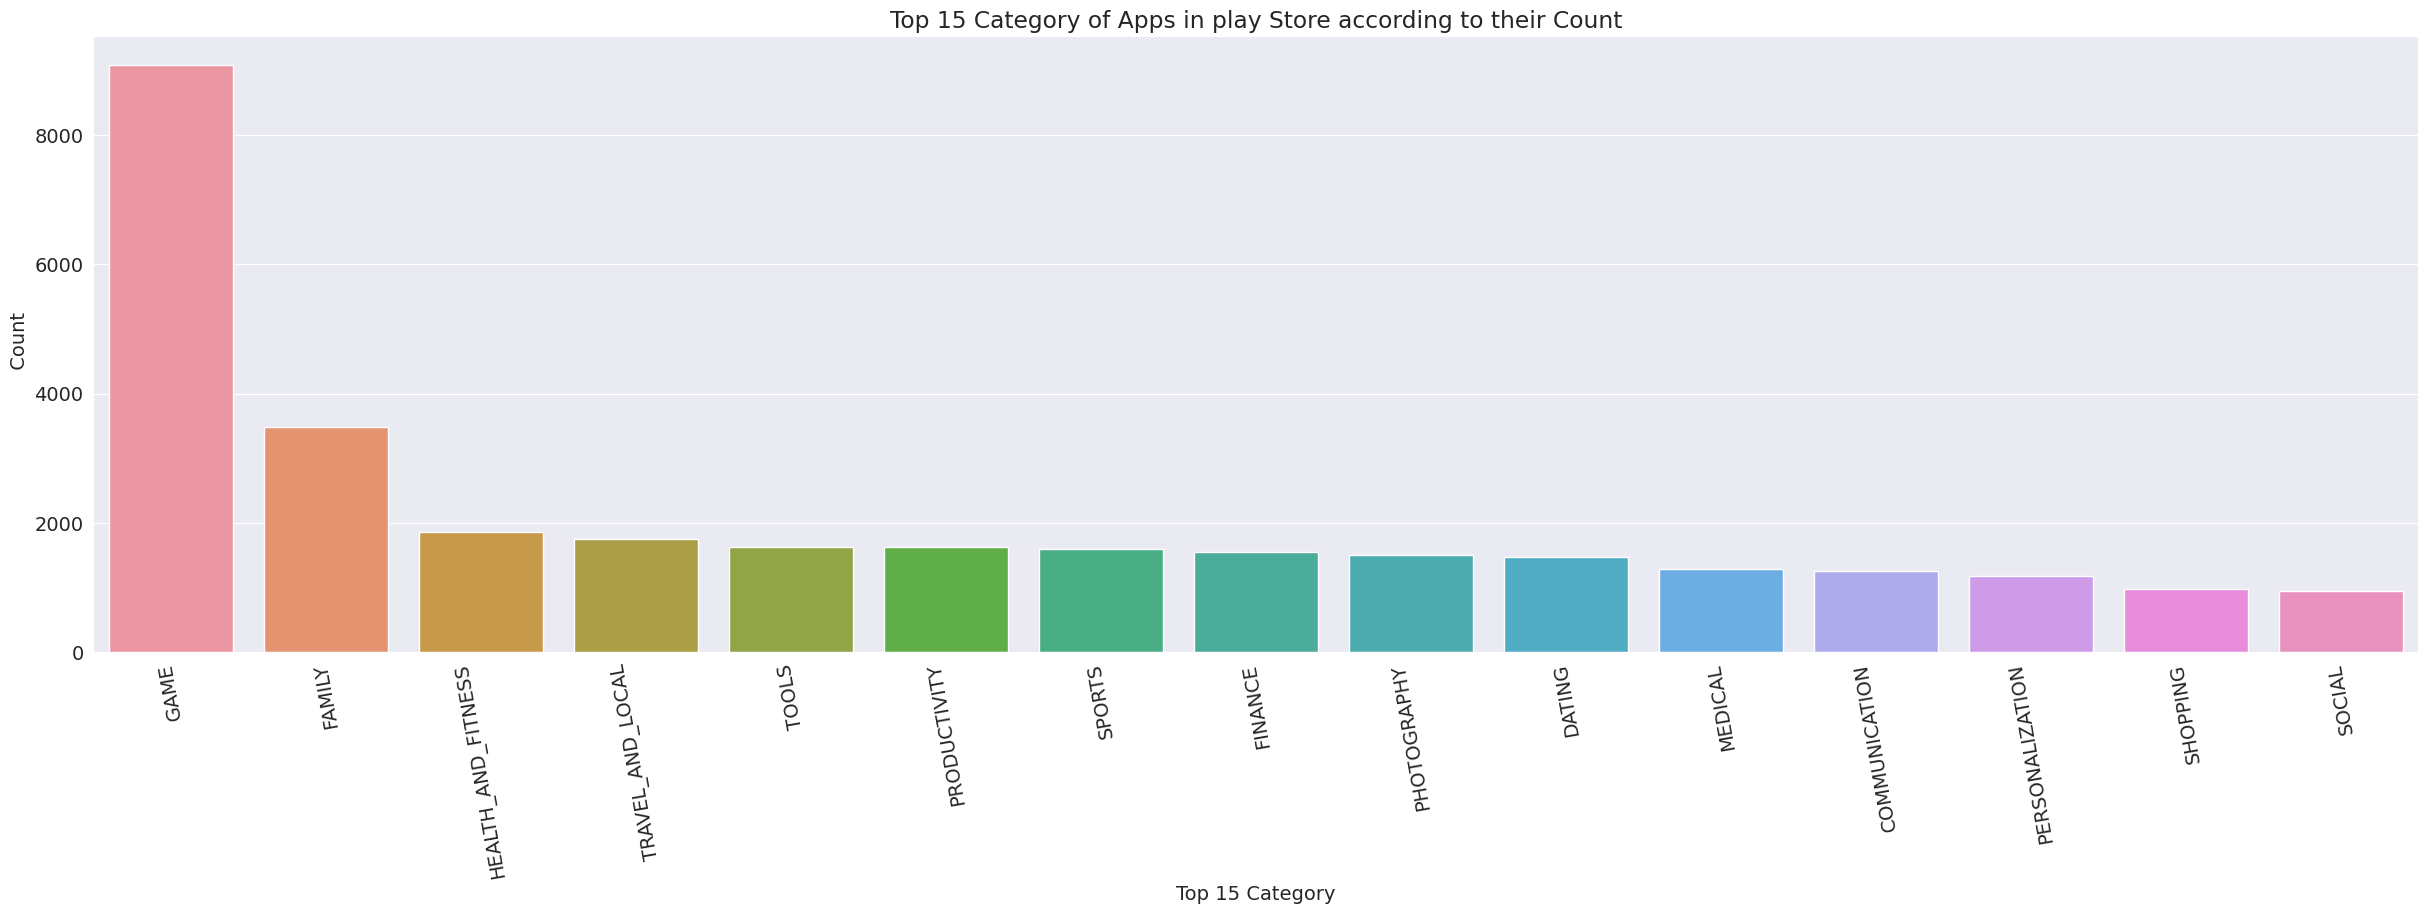

In [ ]:
# plotting the graph: Top 15 Category on the basis of their Count
plt.figure(figsize=(30,8))
plt.xticks(rotation=100)
sns.barplot(x = highest_15_Category_accordingto_installs.Category, y = highest_15_Category_accordingto_installs.Count)
plt.title('Top 15 Category of Apps in play Store according to their Count')
plt.xlabel('Top 15 Category')
plt.ylabel(' Count');

### Which Category of Apps have most installations?

In [ ]:
highest_15_Category_accordingto_installs = highest_15_Category_accordingto_installs.sort_values('Installs',ascending=False).head(15)
highest_15_Category_accordingto_installs

,Category,Count,Installs
0,GAME,9083,568577400000
8,PHOTOGRAPHY,1494,416127500000
14,SOCIAL,946,283699100000
11,COMMUNICATION,1258,282724000000
4,TOOLS,1633,169725500000
5,PRODUCTIVITY,1619,120234300000
1,FAMILY,3487,102317790000
13,SHOPPING,978,39083500000
3,TRAVEL_AND_LOCAL,1748,33712300000
12,PERSONALIZATION,1171,23657490000


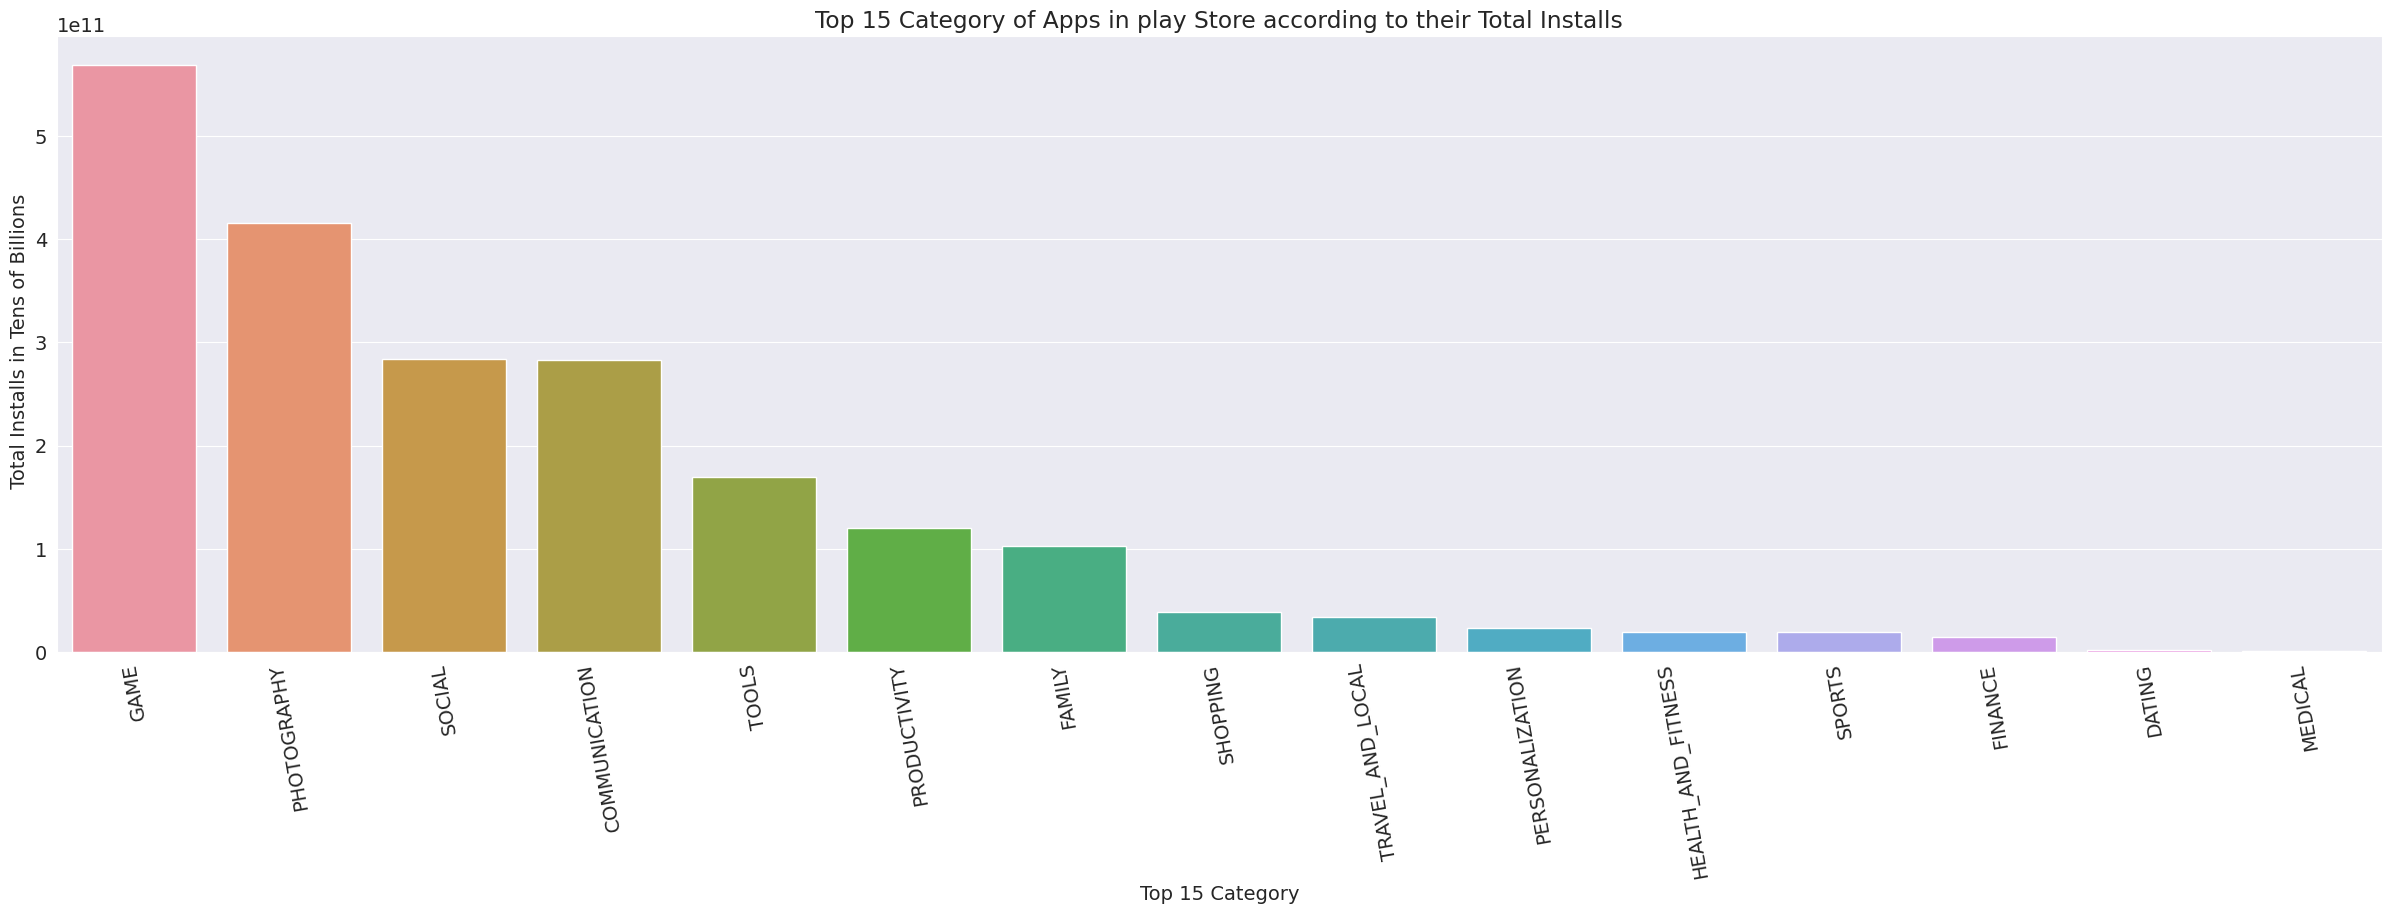

In [ ]:
# plotting the graph: Top 15 Category on the basis of their total Installs
plt.figure(figsize=(30,8))
plt.xticks(rotation=100)
sns.barplot(x = highest_15_Category_accordingto_installs.Category, y = highest_15_Category_accordingto_installs.Installs)
plt.title('Top 15 Category of Apps in play Store according to their Total Installs')
plt.xlabel('Top 15 Category')
plt.ylabel(' Total Installs in Tens of Billions');

### Which Category of Apps have most priced Apps?

In [ ]:
# using value_counts() to count the occurrence of individual Category ,and storing a resultant as a dictionary
dict1 = dict(final_df.Category.value_counts())

# Using the dictionary above to create a new dictionary
dataframe = {'Category':list(dict1.keys())}

# Converting the dictionary above into a dataframe
top_Category = pd.DataFrame(dataframe)
top_Category

,Category
0,GAME
1,FAMILY
2,HEALTH_AND_FITNESS
3,TRAVEL_AND_LOCAL
4,TOOLS
5,PRODUCTIVITY
6,SPORTS
7,FINANCE
8,PHOTOGRAPHY
9,DATING


In [ ]:
# From apps_df dataframe, we will form a new dataframe that will only consist two columns: Category and Price
priced_category = final_df[['Category','Price']]   

# Since there are multiple apps belonging to same Category, so we will take sum of prices of all apps belonging to 1 genre, and sort the column in descending order
priced_category = priced_category.groupby(['Category'])[['Price']].sum()

In [ ]:
# Merging our two dataframes
final_dataframe = top_Category.merge(priced_category, on = 'Category', how = 'left').sort_values('Price', ascending = False).head(10)
final_dataframe

,Category,Price
6,SPORTS,1199.60
10,MEDICAL,813.26
12,PERSONALIZATION,532.20
1,FAMILY,279.30
0,GAME,215.58
21,FOOD_AND_DRINK,0.00
22,HOUSE_AND_HOME,0.00
23,ART_AND_DESIGN,0.00
24,LIBRARIES_AND_DEMO,0.00
25,VIDEO_PLAYERS,0.00


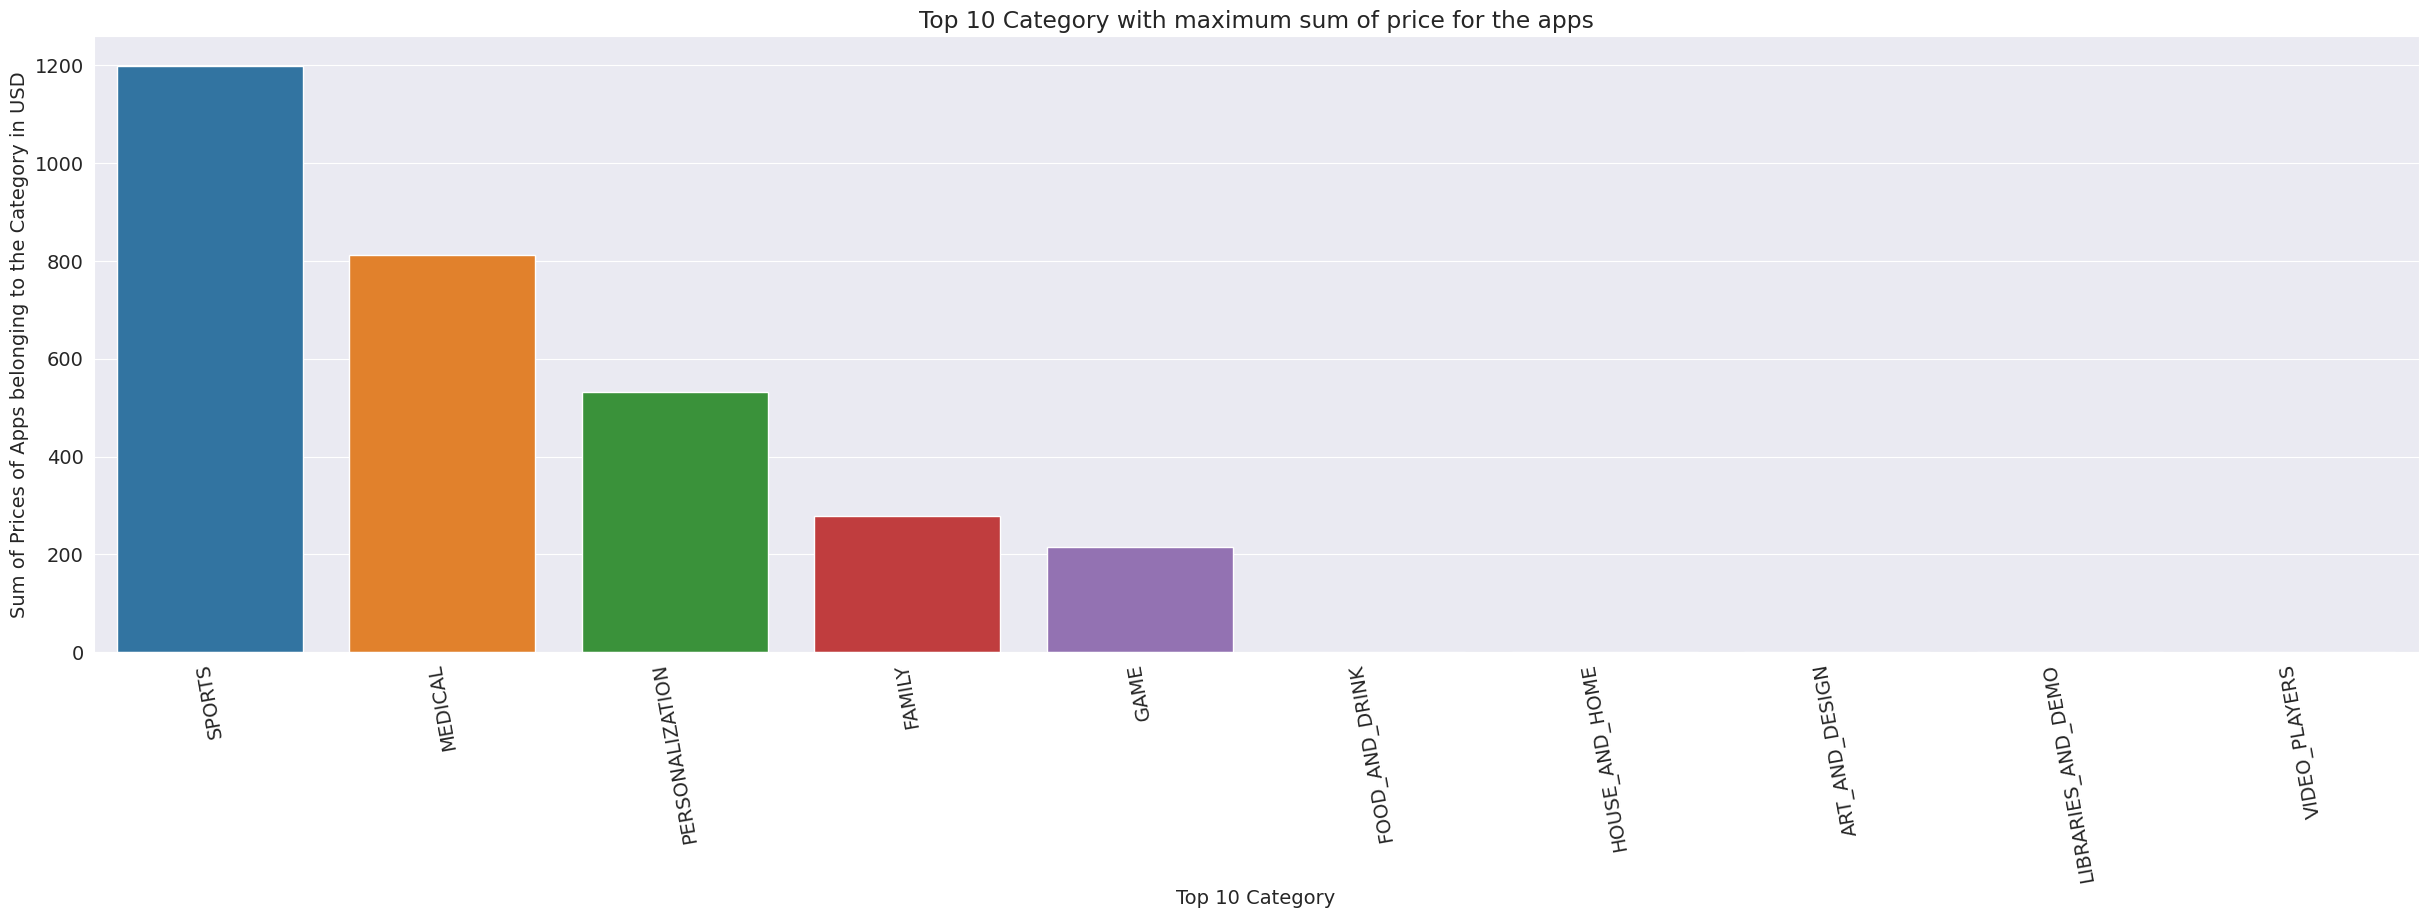

In [ ]:
# plotting into the graph: Top 10 Category with maximum sum of price for the apps

plt.figure(figsize=(30,8))
plt.xticks(rotation=100)
sns.barplot(x = final_dataframe.Category, y = final_dataframe.Price)
plt.xlabel('Top 10 Category')
plt.ylabel('Sum of Prices of Apps belonging to the Category in USD')
plt.title('Top 10 Category with maximum sum of price for the apps');

### Which categories got the most and the least ratings?

In [ ]:
# creating a new dataframe consisting of Category, and their average mean
mean_ratings_accto_Category = final_df.groupby(['Category'])[['Rating']].mean().sort_values('Rating',ascending = False)

cols = list(final_df.Category.unique())

dict3 = {
    'Category':cols
}

df1 = pd.DataFrame(dict3)

mean_ratings_accto_Category = mean_ratings_accto_Category.merge(df1, on = 'Category',how = 'left')
mean_ratings_accto_Category

,Category,Rating
0,AUTO_AND_VEHICLES,4.583513
1,GAME,4.451624
2,HEALTH_AND_FITNESS,4.436969
3,FOOD_AND_DRINK,4.373538
4,PRODUCTIVITY,4.367264
5,FAMILY,4.365988
6,PHOTOGRAPHY,4.358501
7,BOOKS_AND_REFERENCE,4.350997
8,EVENTS,4.335256
9,PERSONALIZATION,4.333219


In [ ]:
# top 15 Category with highest ratings
highest_Ratings_top_15_Category = mean_ratings_accto_Category.head(15)
highest_Ratings_top_15_Category

,Category,Rating
0,AUTO_AND_VEHICLES,4.583513
1,GAME,4.451624
2,HEALTH_AND_FITNESS,4.436969
3,FOOD_AND_DRINK,4.373538
4,PRODUCTIVITY,4.367264
5,FAMILY,4.365988
6,PHOTOGRAPHY,4.358501
7,BOOKS_AND_REFERENCE,4.350997
8,EVENTS,4.335256
9,PERSONALIZATION,4.333219


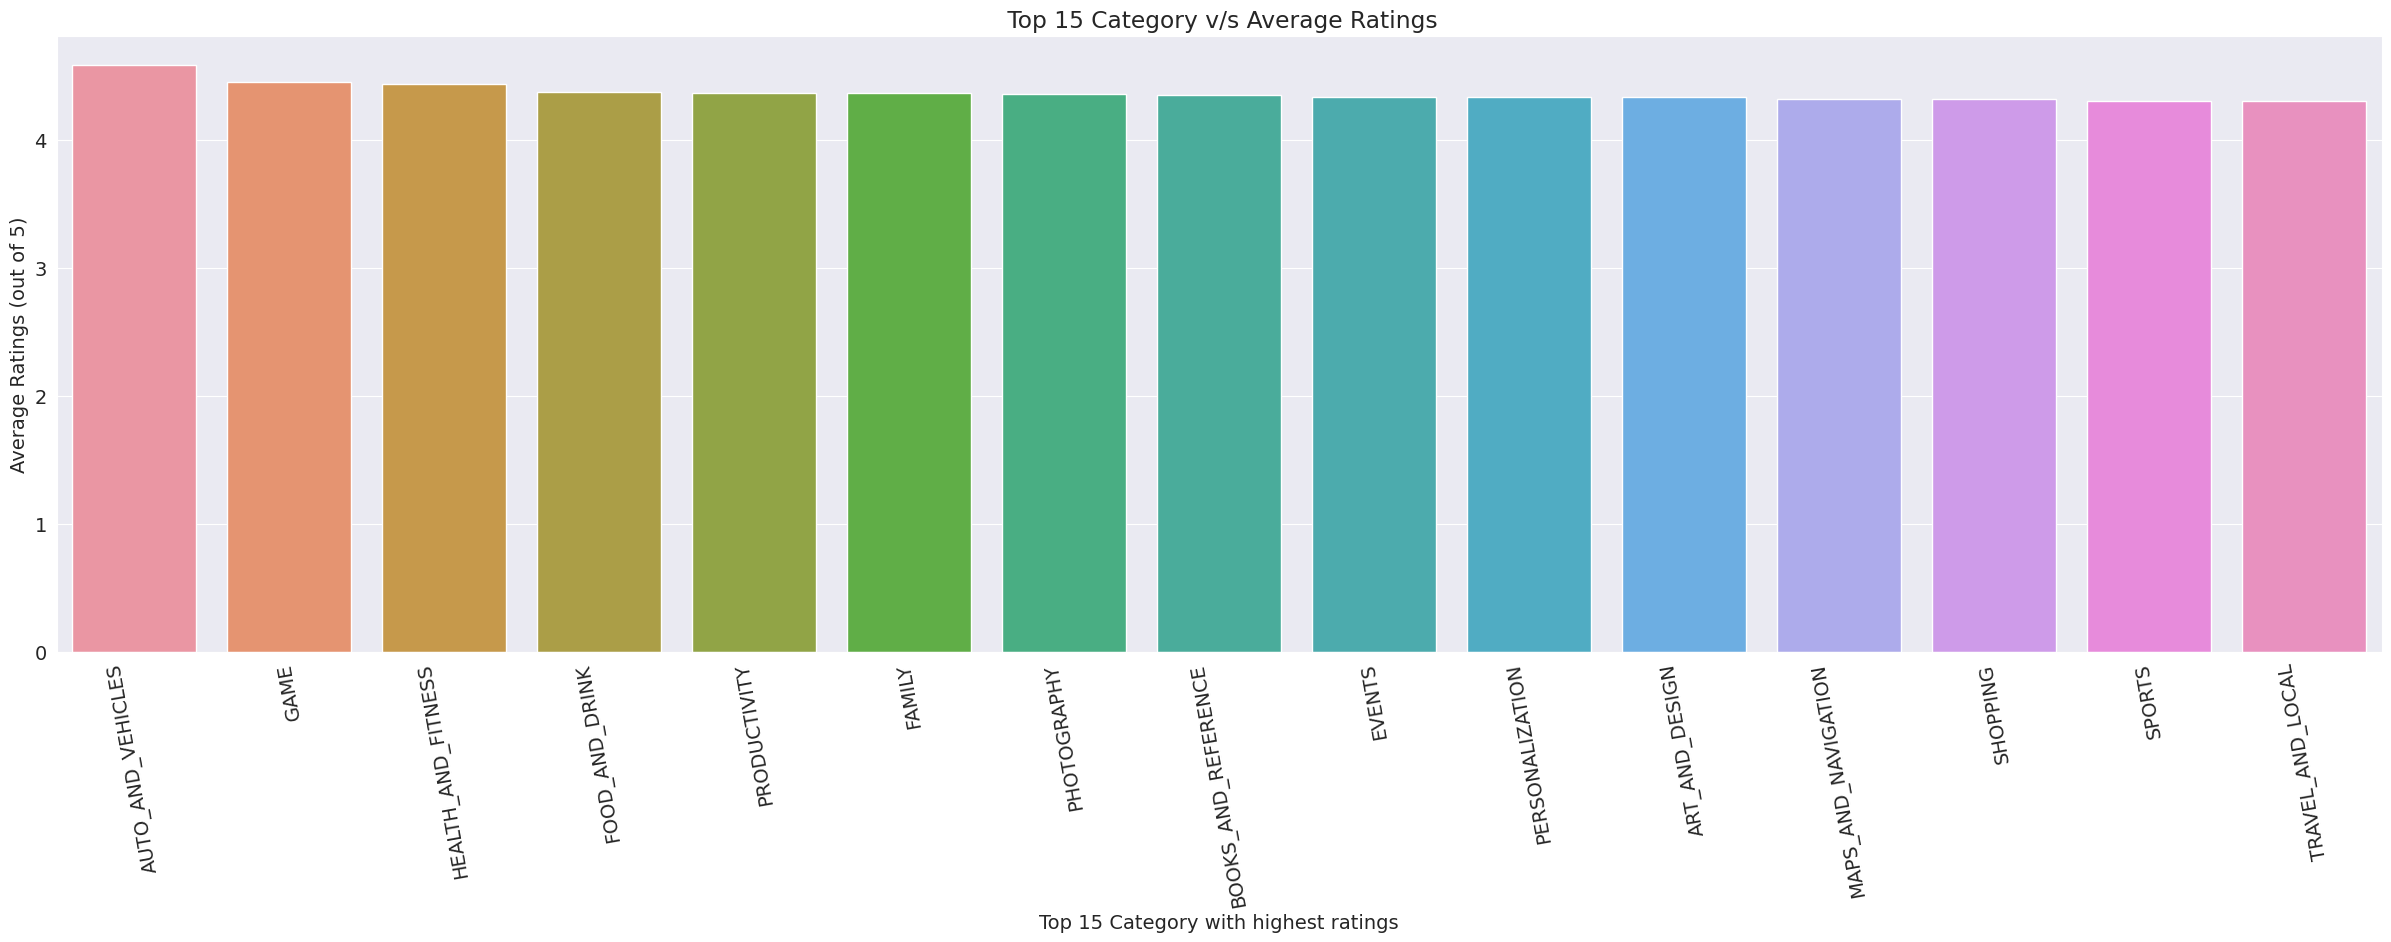

In [ ]:
# plotting the Category vs average Ratings
plt.figure(figsize=(30,8))
plt.xticks(rotation=100)
sns.barplot(x = highest_Ratings_top_15_Category.Category, y = highest_Ratings_top_15_Category.Rating)
plt.xlabel('Top 15 Category with highest ratings')
plt.ylabel('Average Ratings (out of 5)')
plt.title(' Top 15 Category v/s Average Ratings');

In [ ]:
# top 15 Category with lowest ratings
lowest_Ratings_top_15_Category = mean_ratings_accto_Category.tail(15)
lowest_Ratings_top_15_Category

,Category,Rating
18,BEAUTY,4.263722
19,COMICS,4.262500
20,EDUCATION,4.256206
21,BUSINESS,4.252519
22,PARENTING,4.249407
23,COMMUNICATION,4.245866
24,VIDEO_PLAYERS,4.244410
25,NEWS_AND_MAGAZINES,4.223368
26,LIFESTYLE,4.204310
27,SOCIAL,4.185307


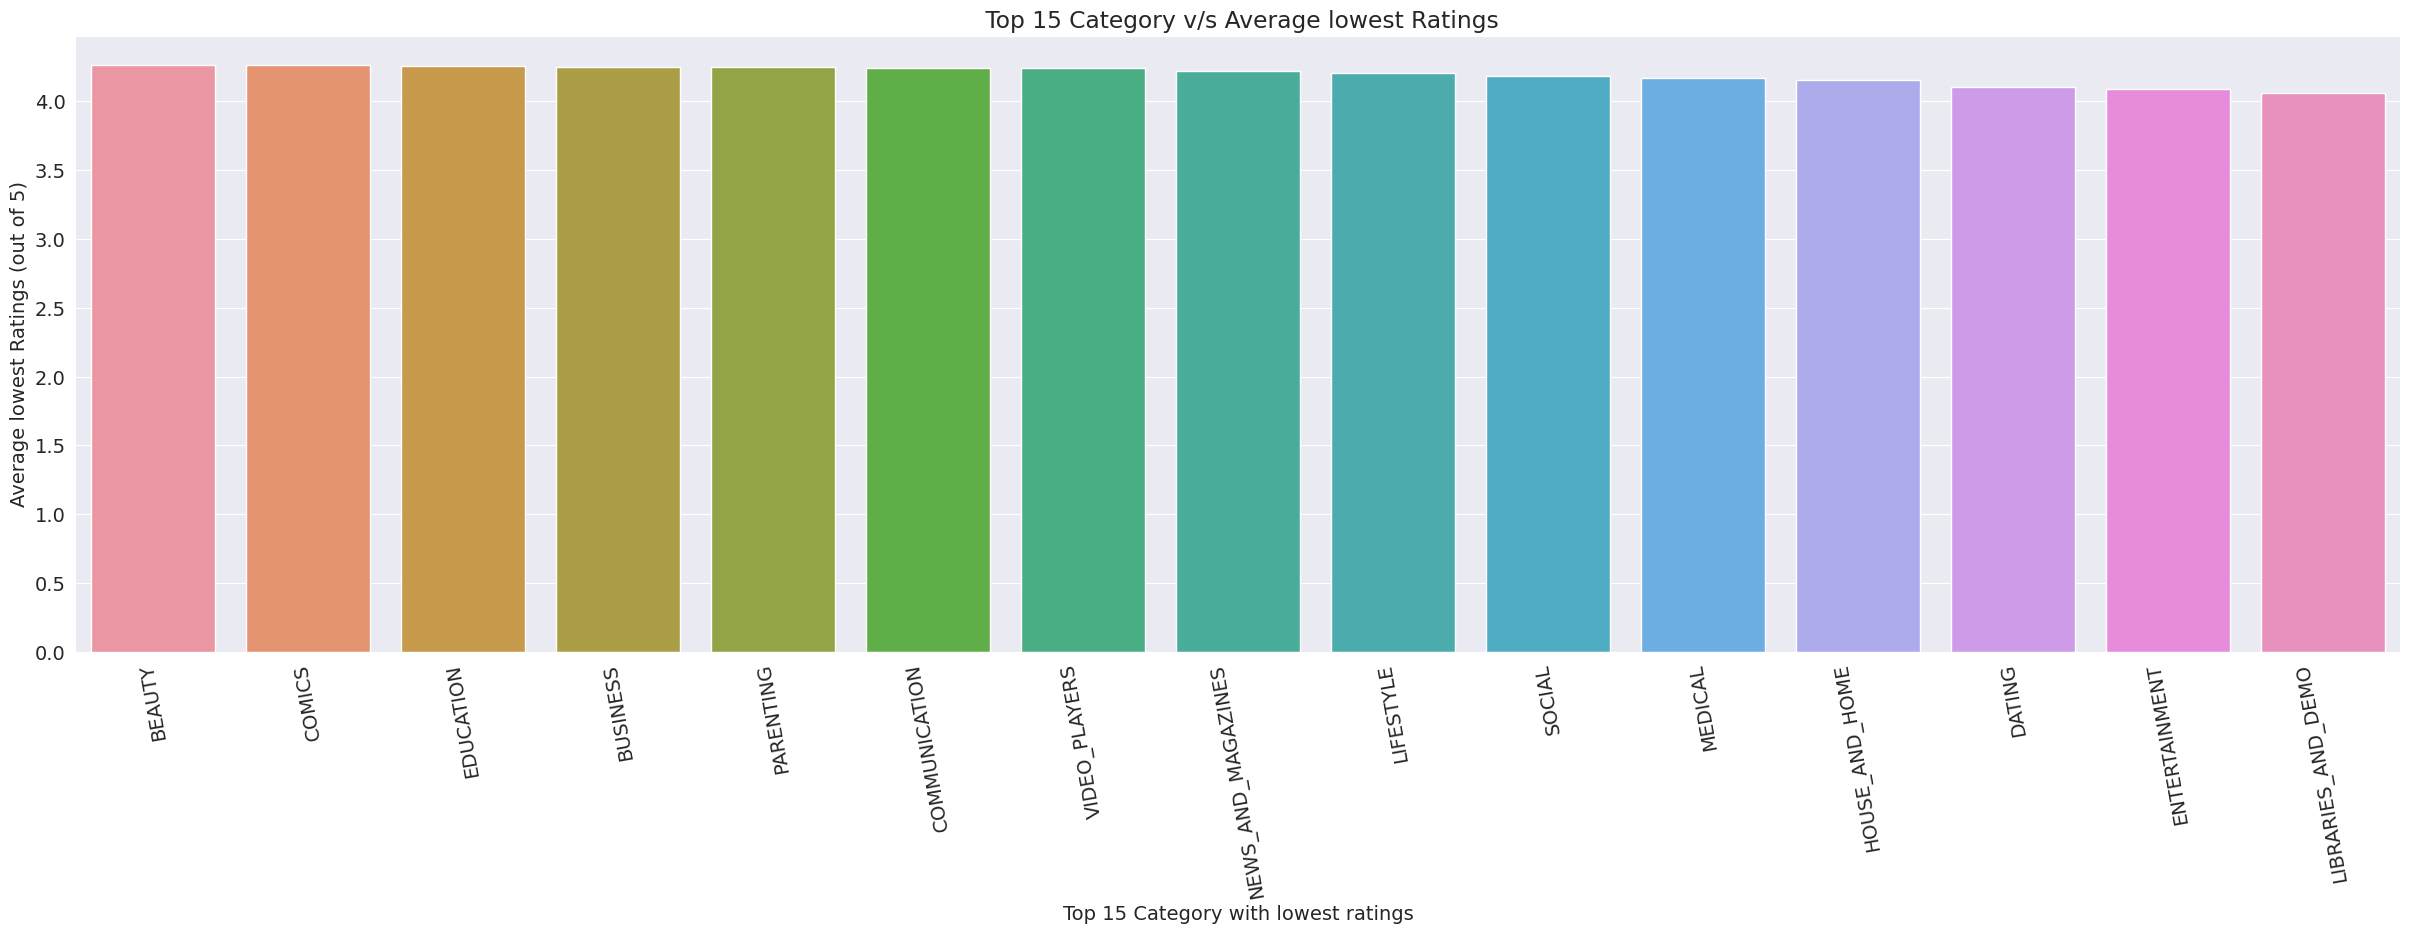

In [ ]:
# plotting the Category vs average lowest Ratings
plt.figure(figsize=(30,8))
plt.xticks(rotation=100)
sns.barplot(x = lowest_Ratings_top_15_Category.Category, y = lowest_Ratings_top_15_Category.Rating)
plt.xlabel('Top 15 Category with lowest ratings')
plt.ylabel('Average lowest Ratings (out of 5)')
plt.title(' Top 15 Category v/s Average lowest Ratings');

### Lets check the probablity of rating distribution of the apps.

In [ ]:
ratings = final_df[['Rating']]
ratings

,Rating
0,4.0
2,4.0
4,4.0
6,4.0
8,4.0
...,...
70944,4.1
70945,4.1
70946,4.1
70947,4.1


<ipython-input-683-4ca3fd67ba82>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x = ratings.Rating,color = 'green',shade = True)


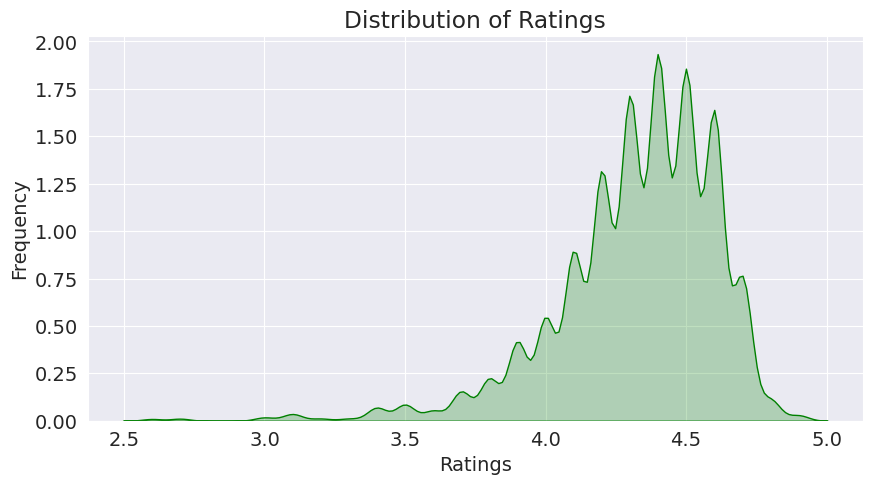

In [ ]:
#plotting the distributing if rating in the graph using kdeplot which is used for visualizing single vatiable in the dataframe.
plt.figure(figsize=(10,5))
sns.kdeplot(x = ratings.Rating,color = 'green',shade = True)
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.title('Distribution of Ratings');

The probability distribution of the rating ranges from 2 to 5 can be seen with the kdeplot. Therefore, after visualizing the ratings, we can say that the majority of them were between 3.5 and 5. Very few ratings have a rating of less than 3.


### What are the number apps in different categories with respect to their type(Free/paid) ?

In [ ]:
# creating a dataframe consisting different category ,and their app's types (Paid/Free)
x1 = final_df.groupby(['Category','Type'])[['App']].count().reset_index()

# Creating a new dataframe that only consists of Catogeries that have Free apps and their count
x2 = x1[x1['Type'] == 'Free'].rename(columns={'App':'Free'}).drop('Type',axis = 1)

# Creating a new dataframe that only consists of Catogeries that have Paid apps and their count
x3 = x1[x1['Type'] == 'Paid'].rename(columns={'App':'Paid'}).drop(columns=['Type'])

Here, the index label column is added by the reset_index() function, which changes the dataframe object into a pure dataframe.

In [ ]:
# Merging the two dataframes and creating a new dataframe that consists of two new columns from the Type column: Free and Paid
total_count = x2.merge(x3,on = 'Category',how = 'left').fillna(0)

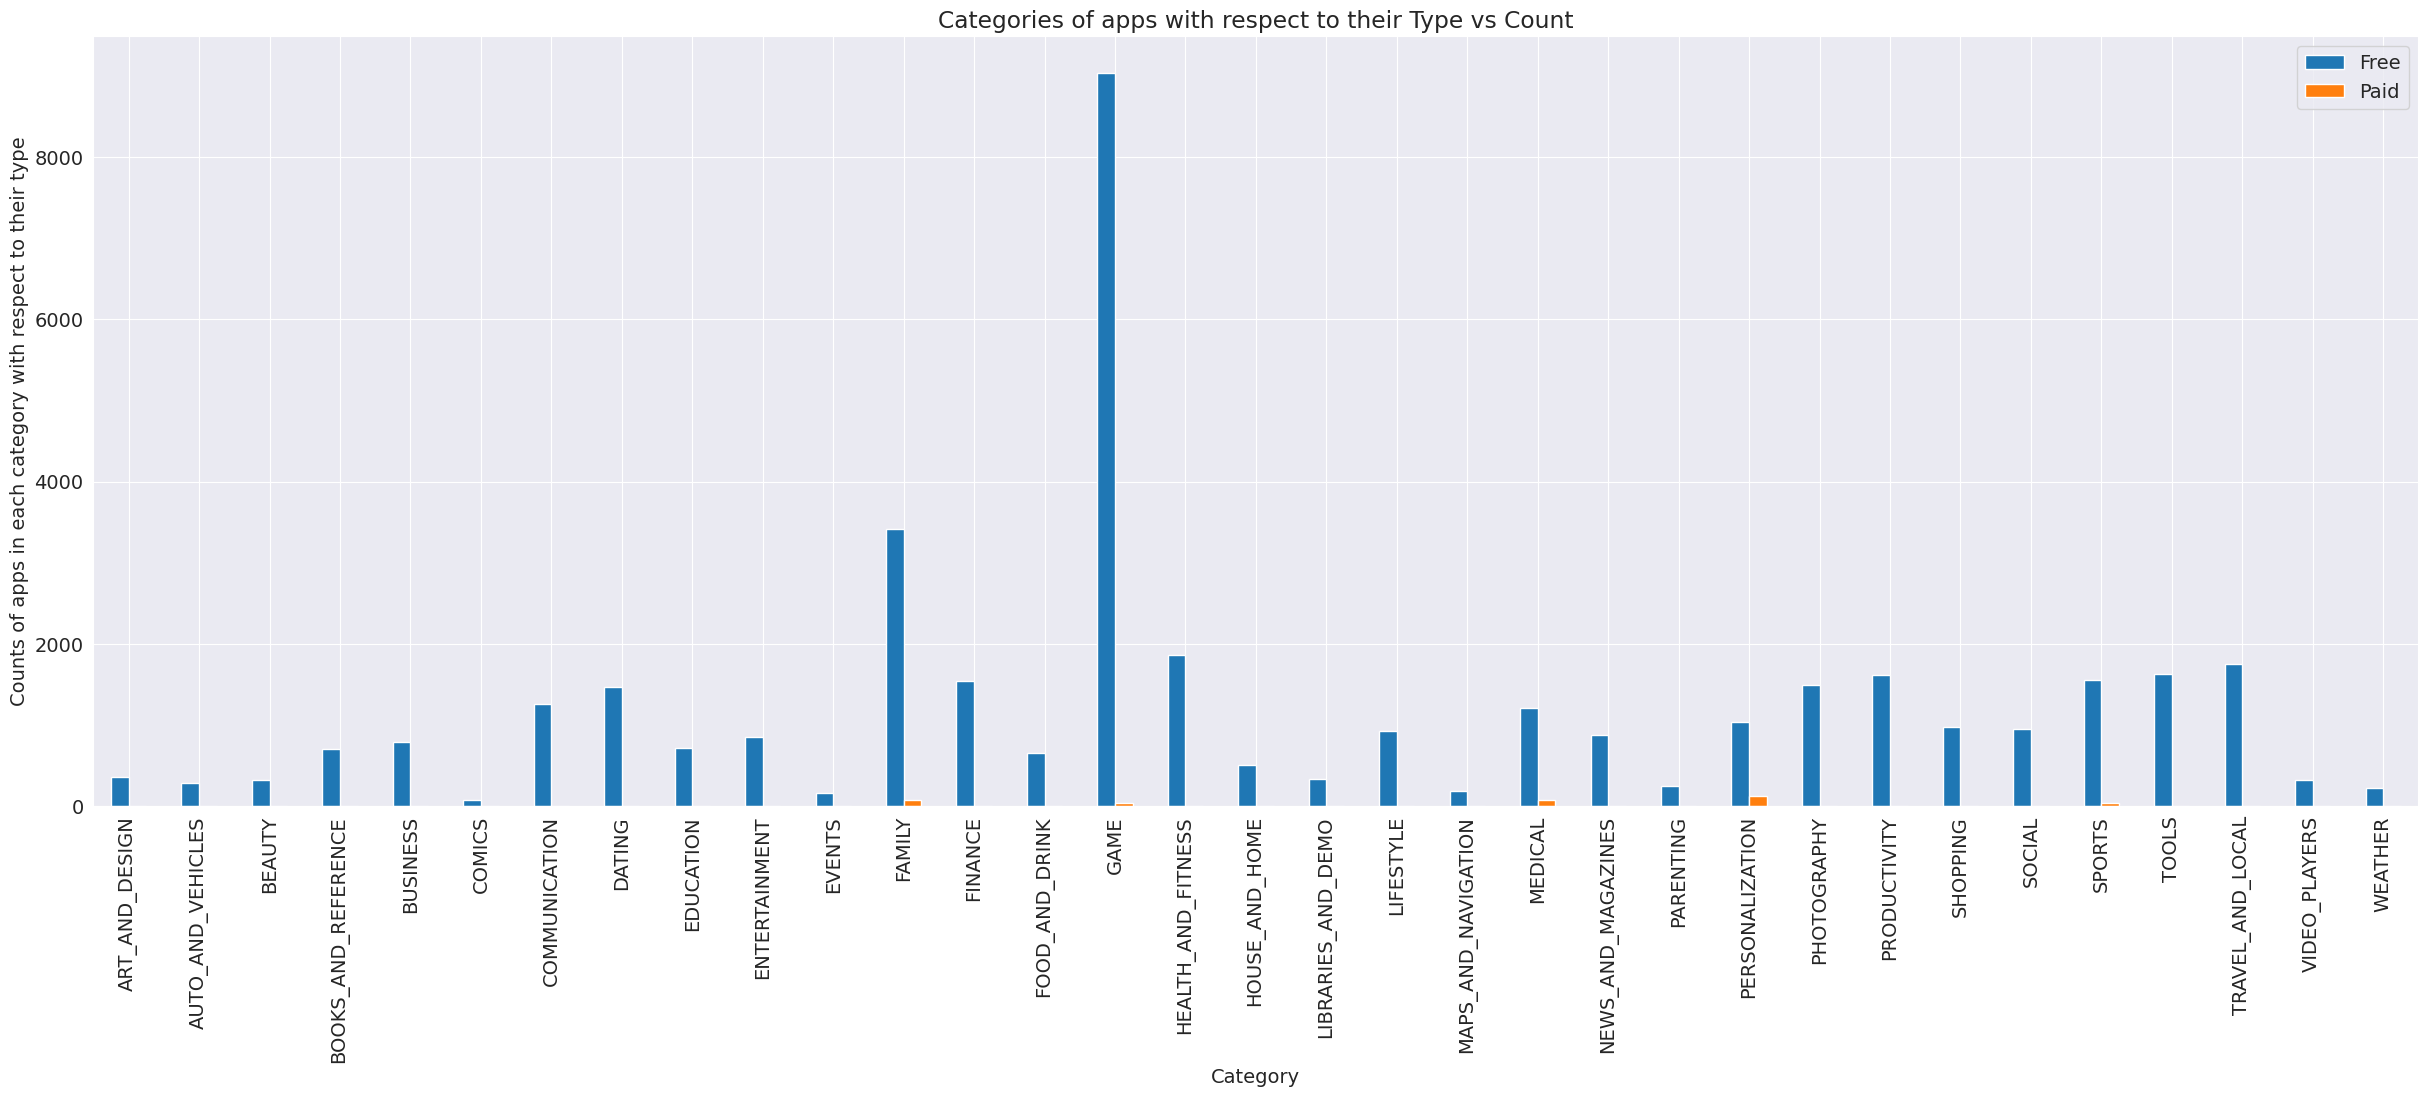

In [ ]:
# equivalent to bar diagram above, only difference being stacked = False
total_count.set_index('Category').plot(kind = 'bar', stacked = False, figsize = (30,10));
plt.xlabel("Category")
plt.ylabel('Counts of apps in each category with respect to their type')
plt.title("Categories of apps with respect to their Type vs Count");

We can easily observe that the Game category held the majority of free apps and the Personalization category has highest paid apps. Similarly, we can draw the conclusion that there are significantly fewer paid apps across all categories than there are free apps.

In [ ]:
Installed_count = final_df.groupby(['Category','Type'])[['Installs']].sum().reset_index()

In [ ]:
## using np.log10() function to calculate the logarithm of values in Installs column
Installed_count['log_installs'] = np.log10(Installed_count.Installs)

The install values for paid and unpaid were considerably different in this particular case. Installs of free apps were significantly higher than those for paid apps. Some paid apps have thousands of installations, while some free apps have billions. Therefore, we calculated the logarithm of the values in the Installs column in order to get the right concept and draw the bar diagram.

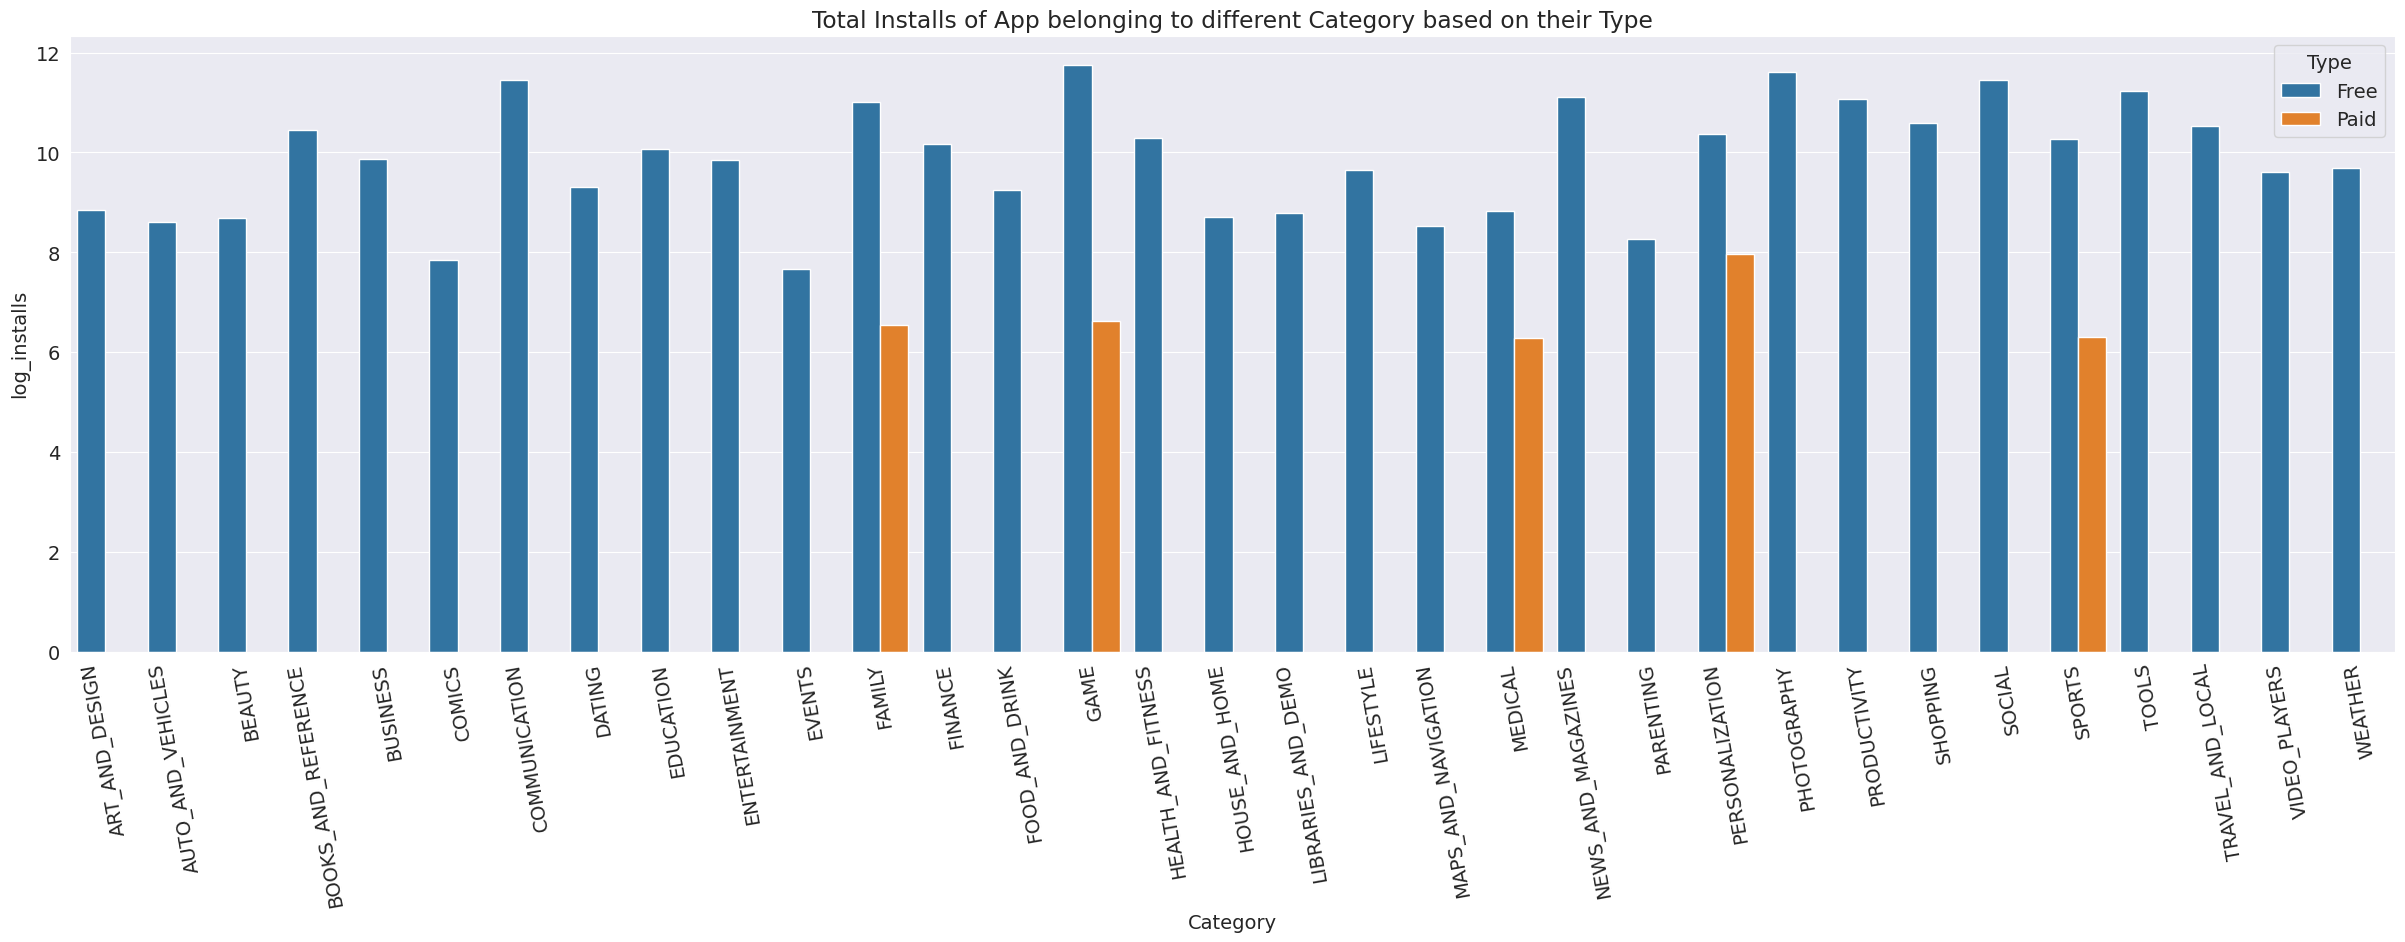

In [ ]:
# plotting in the graph
plt.figure(figsize=(30,8))
plt.xticks(rotation=100)
plt.xlabel('Category')
plt.ylabel('Installs in Billions')
sns.barplot(data= Installed_count, x= 'Category', y= 'log_installs',hue='Type')
plt.title('Total Installs of App belonging to different Category based on their Type');

We can draw the conclusion that a lot more free apps were installed than paid apps, by a wide margin.

### Size of Apps affecting the app installations

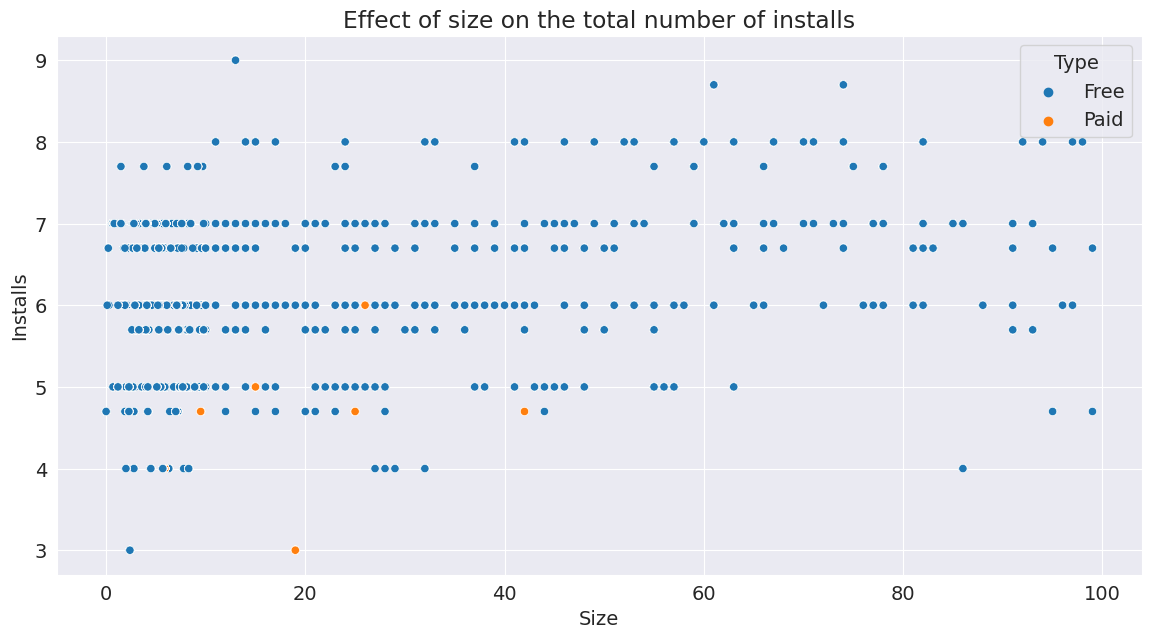

In [ ]:
# plotting the scatterplot
plt.figure(figsize=(14,7))
plt.title('Effect of size on the total number of installs')
sns.scatterplot(x = final_df.Size, y = np.log10(final_df.Installs), hue = final_df.Type)
plt.show();

We can see that from the scatterplot above that an app's size directly influences how well it the apps are installed. Large-sized apps have a lesser chance of being downloaded than smaller-sized ones.

### Lets check the probablity of Size distribution of the apps.

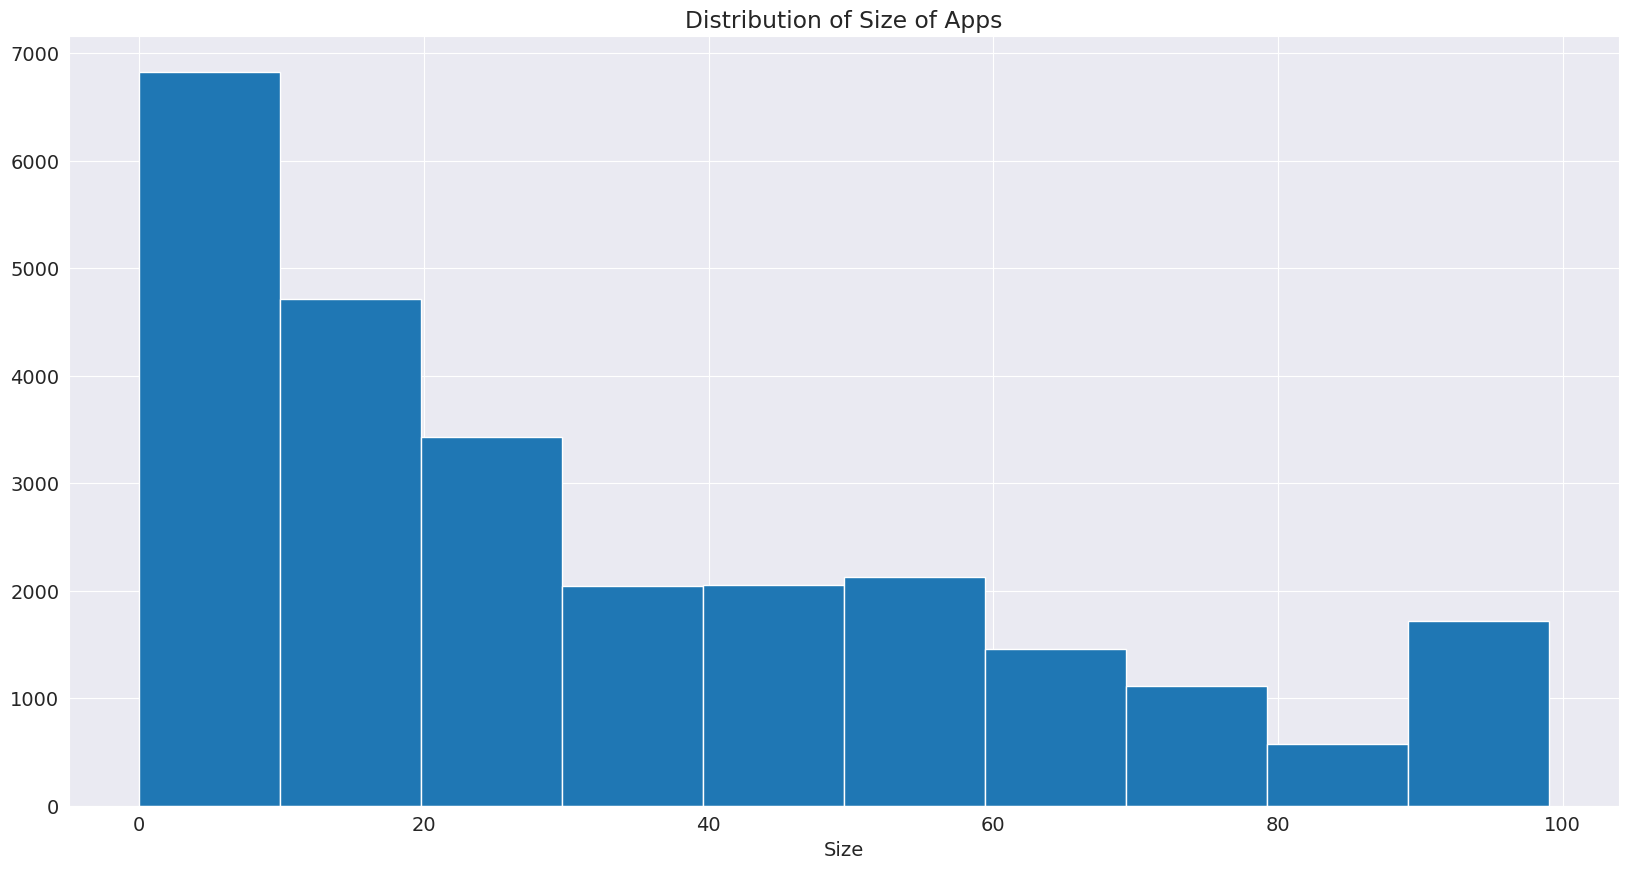

In [ ]:
# plotting the histogram
plt.title('Distribution of Size of Apps')
plt.xlabel('Size')
plt.hist(final_df.Size);

In [ ]:
final_df.Size[final_df.Size <= 10].size

7233

There are 7200+ apps that has size of 0 to 10 mb only.

In [ ]:
final_df.Size[(final_df.Size > 20) & (final_df.Size <= 50)].size

7176

We can easily see from the cell and histogram above that there are more than 7000+ apps with sizes ranging from 20 to 50 MB

In [ ]:
final_df.Size[(final_df.Size > 80) & (final_df.Size <= 100)].size

2296

There are only 2296 apps that have app size raning from 80 to 100 MB.

# Sentiment Analysis

## Natural Langauge processing

#### For Sentiment Analysis, we are going to use basic Natural Language Processing to analysis the reviews of the app given by the users.

#### Natural Language Processing (NLP) is the capability of computer software to comprehend human language in both written and spoken forms. Essentially, NLP enables computers to understand and interpret natural language in a way that is similar to humans. By utilizing artificial intelligence, NLP processes real-world input and translates it into a format that a computer can understand.

#### Here we are going to use basic NLP analysis on column "Translated_Review" and "Sentiment" which includes preprocess the data, removing stopwords, stemming and lemmatization.

In [ ]:
final_df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Translated_Review,Sentiment
0,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,This help eating healthy exercise regular basis,2
2,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Works great especially going grocery store,2
4,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Best idea us,2
6,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Best way,2
8,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Amazing,2
...,...,...,...,...,...,...,...,...,...,...
70944,Housing-Real Estate & Property,LIFESTYLE,4.1,28301,NaN,1000000,Free,0.0,Most ads older many agents ..not much owner po...,2
70945,Housing-Real Estate & Property,LIFESTYLE,4.1,28301,NaN,1000000,Free,0.0,"If photos posted portal load, fit purpose. I'm...",2
70946,Housing-Real Estate & Property,LIFESTYLE,4.1,28301,NaN,1000000,Free,0.0,"Dumb app, I wanted post property rent give opt...",1
70947,Housing-Real Estate & Property,LIFESTYLE,4.1,28301,NaN,1000000,Free,0.0,I property business got link SMS happy perform...,2


In [ ]:
final_df.dropna(inplace=True)
final_df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Translated_Review,Sentiment
0,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,This help eating healthy exercise regular basis,2
2,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Works great especially going grocery store,2
4,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Best idea us,2
6,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Best way,2
8,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Amazing,2
...,...,...,...,...,...,...,...,...,...,...
70857,Hotspot Shield Free VPN Proxy & Wi-Fi Security,TOOLS,4.2,1116393,8.2,50000000,Free,0.0,FORTNITE,0
70858,Hotspot Shield Free VPN Proxy & Wi-Fi Security,TOOLS,4.2,1116393,8.2,50000000,Free,0.0,Thinks,0
70859,Hotspot Shield Free VPN Proxy & Wi-Fi Security,TOOLS,4.2,1116393,8.2,50000000,Free,0.0,Love It,2
70860,Hotspot Shield Free VPN Proxy & Wi-Fi Security,TOOLS,4.2,1116393,8.2,50000000,Free,0.0,really great,2


In [ ]:
sentiment_analysis=pd.concat([final_df.Translated_Review,final_df.Sentiment],axis=1)
sentiment_analysis

,Translated_Review,Sentiment
0,This help eating healthy exercise regular basis,2
2,Works great especially going grocery store,2
4,Best idea us,2
6,Best way,2
8,Amazing,2
...,...,...
70857,FORTNITE,0
70858,Thinks,0
70859,Love It,2
70860,really great,2


Creating a new datafrane sentiment_analysis where we only have two columns "Translated_Review" and "Sentiment".

The dataframe above now has no nan values and our goal is to categorize reviews based on their sentiment. To do that, we will use Translated_Review as our independent variable (x column) and Sentiment as our dependent variable (y column) that we want to predict.

In [ ]:
sentiment_analysis.Sentiment.unique()

array([2, 0, 1], dtype=int32)

In [ ]:
dict1 = dict(sentiment_analysis.Sentiment.value_counts())

# Using the dictionary above to create a new dictionary
dataframe = {'Sentiment':list(dict1.keys()),
             'Count':list(dict1.values())}

# Converting the dictionary above into a dataframe
sentiment_count = pd.DataFrame(dataframe)
sentiment_count

,Sentiment,Count
0,2,16475
1,1,6333
2,0,3225


We have already converted unique value into numeric value in the sentiment_df data cleaning part. so we dont need to do it again. Also, 2 refer as positive, 1 refer has negative and 0 refer as neutral.

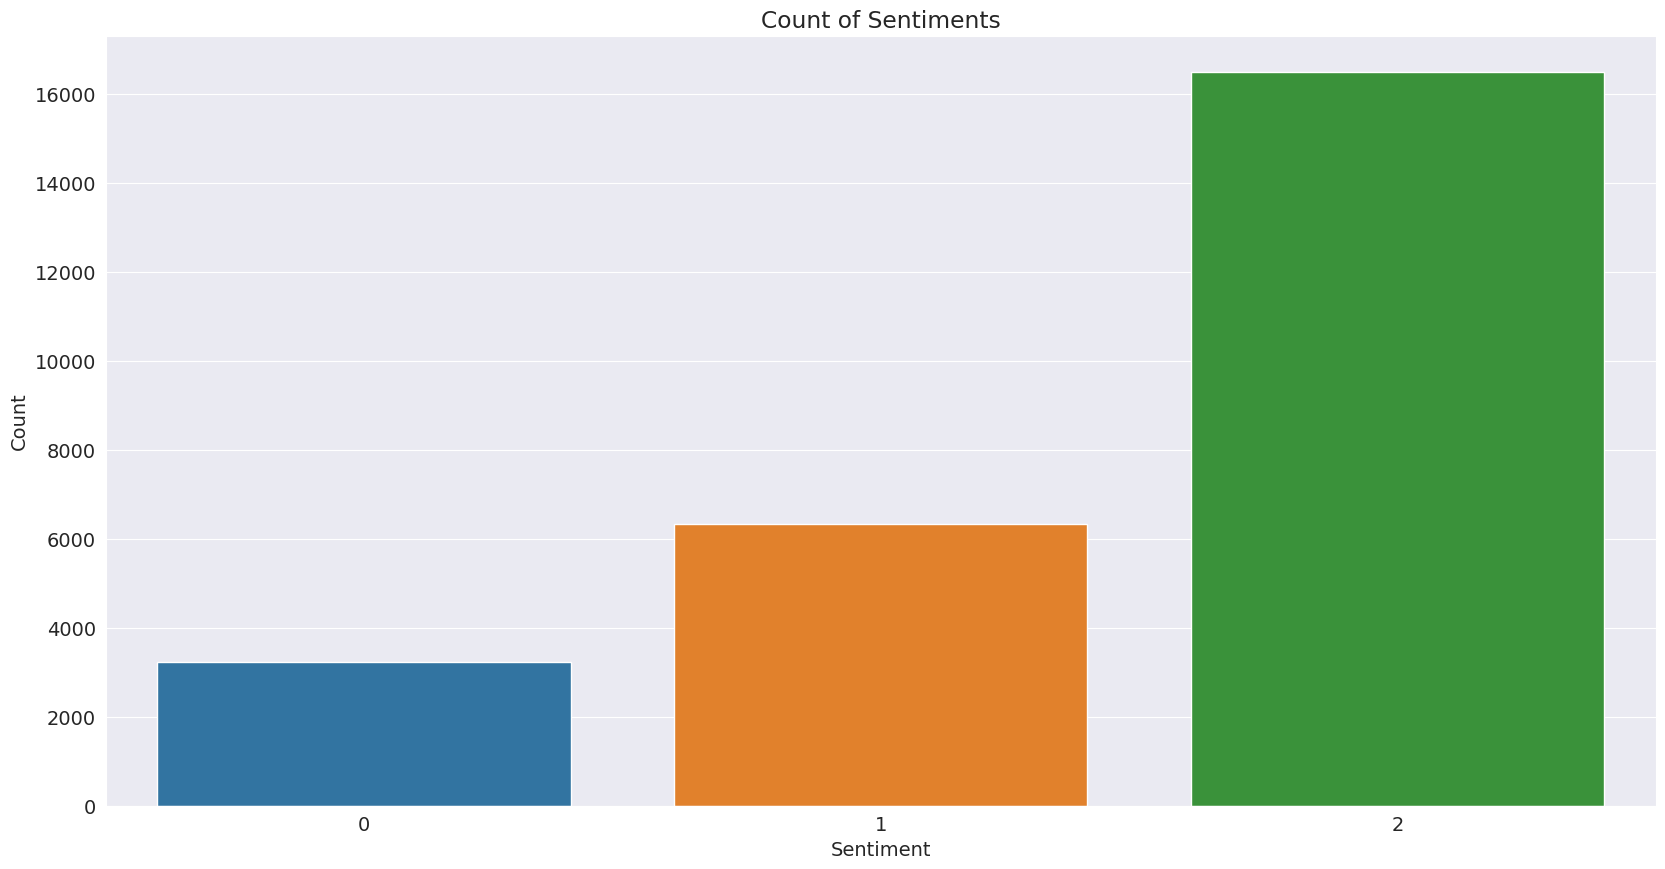

In [ ]:
# Plot the count of sentiments
# Count of each sentiment
sentiment_counts = sentiment_analysis.Sentiment.value_counts()

# Bar plot
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Count of Sentiments")
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Text Cleaning and Preprocessing

#### Therefore, we must clean up our data before preprocessing it for use in the model. The characters that are not letters must first be removed.

### Text cleaning

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
text_list=[]
for i in sentiment_analysis.Translated_Review:
    text=re.sub("[^a-zA-Z]"," ",i)
    text=text.lower()
    text=nltk.word_tokenize(text)
    lemma=nltk.WordNetLemmatizer()
    ps = PorterStemmer()
    text= [ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text=[lemma.lemmatize(word) for word in text]
    text=" ".join(text)
    text_list.append(text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
text_list[:10]

['help eat healthi exercis regular basi',
 'work great especi go groceri store',
 'best idea u',
 'best way',
 'amaz',
 'look forward app',
 'help site help food get',
 'good',
 'use inform amount spell error question valid inform share fix star given',
 'thank great app add arthriti eye immun kidney liver detox food plea']

In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


In [ ]:
pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
max_features = 1000
vectorizer = CountVectorizer(max_features=max_features, stop_words="english")
sparse_matrix = vectorizer.fit_transform(text_list).toarray()
all_words = vectorizer.get_feature_names_out()
print("Most used 100 words: ", all_words[:100])

Most used 100 words:  ['abil' 'abl' 'absolut' 'accept' 'access' 'accident' 'account' 'accur'
 'achiev' 'action' 'activ' 'actual' 'ad' 'add' 'addict' 'addit' 'address'
 'advanc' 'adventur' 'advert' 'advertis' 'advic' 'age' 'ago' 'aim' 'alarm'
 'alert' 'allow' 'alon' 'alot' 'alreadi' 'alway' 'amaz' 'amazon' 'amino'
 'android' 'angri' 'anim' 'annoy' 'anoth' 'answer' 'anymor' 'anyon'
 'anyth' 'anywher' 'apart' 'app' 'appear' 'applic' 'appoint' 'appreci'
 'area' 'arena' 'articl' 'asap' 'ask' 'attack' 'attempt' 'attent' 'auto'
 'automat' 'avail' 'avoid' 'aw' 'away' 'awesom' 'babi' 'background' 'bad'
 'balanc' 'ball' 'bank' 'bar' 'bare' 'base' 'basic' 'batteri' 'battl'
 'beat' 'beauti' 'becom' 'begin' 'believ' 'besid' 'best' 'better' 'big'
 'bird' 'bit' 'black' 'block' 'blood' 'board' 'bodi' 'book' 'booster'
 'bore' 'bother' 'bought' 'box']


Now, the data is ready for model traning.

## Lets split the data for training and testing

In [ ]:
# Splitting the dataset into the Training set and Test set
x= sparse_matrix
y = sentiment_analysis.iloc[:,1].values
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

### Naive Bayes Classifier

In [ ]:
# Now Fitting Naive Bayes classifier to the Training set
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train,y_train)

GaussianNB()

In [ ]:
# Predicting the Test set results
y_pred = nb.predict(x_test)

In [ ]:
#Comparing predicted labels with actual labels
from sklearn.metrics import accuracy_score   
nb_accuracy = accuracy_score(y_test, y_pred)
print(nb_accuracy)

0.4862684847320914


#### Accuracy is 50% according to Naive Bayes Classifier

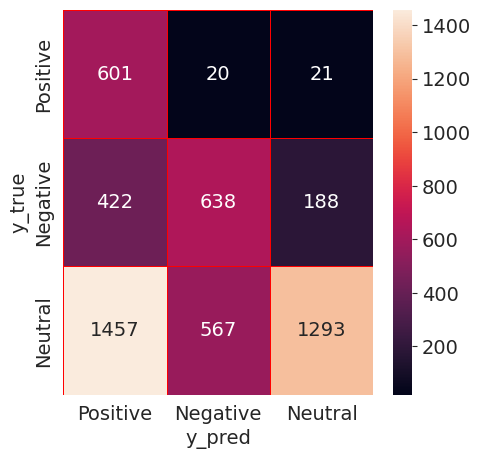

In [ ]:
# Making the Confusion Matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Predicting the Test set results
y_pred = lr.predict(x_test)

In [ ]:
#Comparing predicted labels with actual labels
from sklearn.metrics import  accuracy_score
lr_accuracy = accuracy_score(y_test, y_pred)
print(lr_accuracy)

0.8847705012483196


### Accuracy is 87% according to Logistic Regression

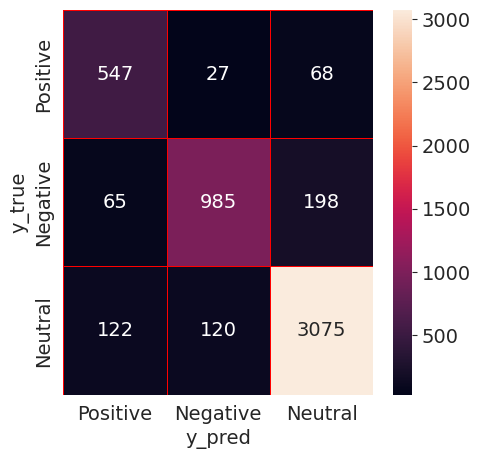

In [ ]:
# Making the Confusion Matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators = 10, random_state=42)
rf.fit(x_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [ ]:
# Predicting the Test set results
y_pred = rf.predict(x_test)

In [ ]:
#Comparing predicted labels with actual labels
from sklearn.metrics import  accuracy_score   
rf_accuracy = accuracy_score(y_test, y_pred)
print(rf_accuracy)

0.8893796811983868


### Accuracy is 89% according to Random Forest Classifier

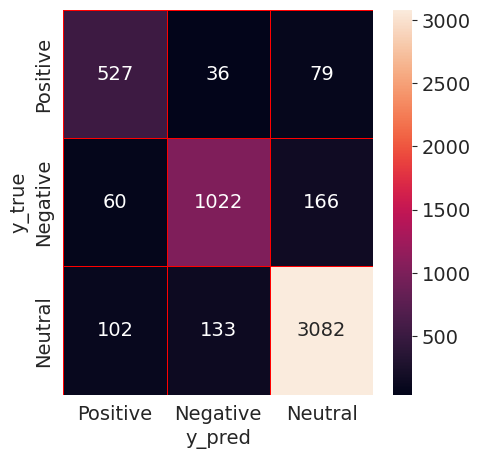

In [ ]:
# Making the Confusion Matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [ ]:
models = pd.DataFrame({
 'Model': ['Logistic Regression', 'GaussianNB', 'Random Forest'],
 'Score': [lr_accuracy*100, nb_accuracy*100, rf_accuracy*100]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,88.937968
0,Logistic Regression,88.477050
1,GaussianNB,48.626848


## Accuracy is 90% according to Random Forest Classifier. In conclusion, We used naive bayes, logistic regression and random forest. According to score table Random Forest Classifier gives us best accurancy like 90% accuracy.